In [1]:
%reset -f
import seaborn as sns
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


## cell X20

In [2]:
parent_dir_output = "/Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/cell_x20" 
file_output = "output_data.txt"
file_output_2pick="output_data_2_peak.txt"
output_full_df = "output_z_700nm.txt"
output_path = os.path.join(parent_dir_output, file_output)
output_path_full_df = os.path.join(parent_dir_output, output_full_df)
output_path_full_2pick = os.path.join(parent_dir_output, file_output_2pick) 
full_output_folder = parent_dir_output
ch_name = ["Vin","Vim"]

## Analysis with 2 pick data

In [334]:

# Load the data nto data frame from the first file where the results in the format  file just with ROI_ind,z_center_ch1,sd_ch1,z_center_ch2,sd_ch2,downsampling,pick_mode
df1 = pd.read_csv(output_path) 

# Load the data for ROIs with pick_mode=2 in the format  file just with ROI_ind,z_center_ch1,sd_ch1,z_center_ch2,sd_ch2,downsampling,pick_mode

df2 = pd.read_csv(output_path_full_2pick )

# Merge the dataframes on 'ROI_ind'(put 'outer' so all rows are included, even if they don't have a match in the other dataframe )

final_df = pd.merge(df1, df2, on='ROI_ind', how='outer')

# To select the some fields for the final table
final_columns = ['ROI_ind', 'z_center_ch1', 'sd_ch1', 'z_center_ch2', 'sd_ch2', 'downsampling', 'pick_mode', 'z_center_ch1_p1', 'sd_ch1_p1', 'z_center_ch1_p2', 'sd_ch1_p2']

final_df = final_df[final_columns] #main data frame to work with 

# Fill NaN values, remember to work on them later maybe
final_df.fillna(np.nan, inplace=True)

#Let's sort it as well
final_df['ROI_index'] = final_df['ROI_ind'].str.extract(r'(\d+)').astype(int)
sorted_df = final_df.sort_values('ROI_index').drop(columns='ROI_index')
sorted_df.reset_index(drop=True, inplace=True) # to update row index 
final_df = sorted_df
# Save the final dataframe to a new CSV file 
final_df.to_csv(full_output_folder+'//final_table.csv', index=False)


Results are saved to the folder: /Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/cell_x20


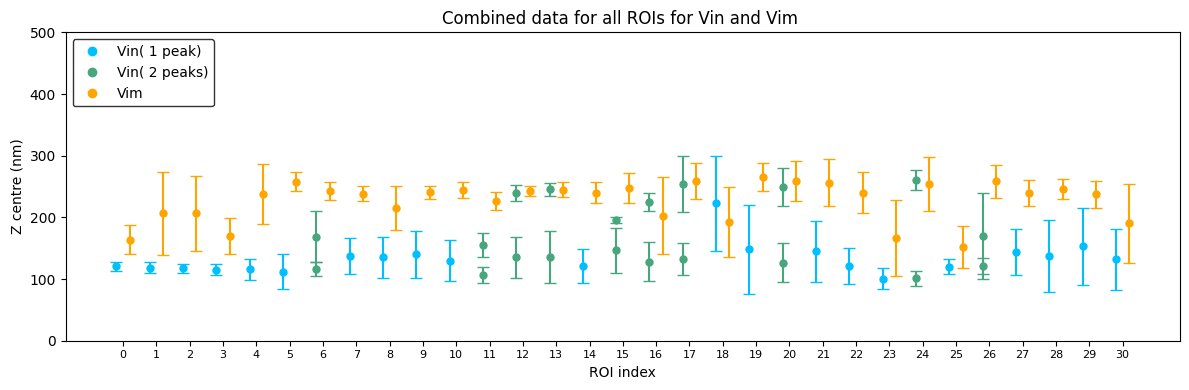

In [335]:

x_values = np.arange(len(final_df))


offset_ch1 = -0.2  
offset_ch2 = 0.2   

plt.figure(figsize=(12, 4))
ax = plt.axes()

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

# To ensure legends are correctly added once for each type
legend_added_for_pick_mode_2 = False

# Vin data plot
for i, row in final_df.iterrows():
    x_base = x_values[i]  # Base x-coord for this ROI
    if row['pick_mode'] == 2:
        # For pick_mode=2, plot both p1 and p2 
        plt.errorbar(x_base + offset_ch1, row['z_center_ch1_p1'], yerr=row['sd_ch1_p1'], fmt='o', color='#47a67e', capsize=4,markersize='5', label=(ch_name[0]+'2 picks') if not legend_added_for_pick_mode_2 else "")
        plt.errorbar(x_base + offset_ch1, row['z_center_ch1_p2'], yerr=row['sd_ch1_p2'], fmt='o', color='#47a67e', capsize=4,markersize='5', label=(ch_name[0]+'2 picks') if not legend_added_for_pick_mode_2 else "")
        legend_added_for_pick_mode_2 = True
    else:
        # For other cases, plot the standard values for Vin  
        plt.errorbar(x_base + offset_ch1, row['z_center_ch1'], yerr=row['sd_ch1'], fmt='o', color='#00bfff', markersize='5', capsize=4, label='Channel 1' if i == 0 else "")
plt.errorbar(x_values + offset_ch2, final_df['z_center_ch2'], yerr=final_df['sd_ch2'], fmt='o', color='#ffa500', capsize=4,markersize='5', label=ch_name[1])

plt.xlabel('ROI index')
plt.ylabel('Z centre (nm)')
plt.title('Combined data for all ROIs for Vin and Vim ')
plt.xticks(x_values, [ind.split('_')[1] for ind in final_df['ROI_ind'].astype(str)], rotation=0, size=8) 
plt.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)
legend_elements = [
    Line2D([0], [0], color='#00bfff', marker='o', linestyle='None', label=ch_name[0]+'( 1 peak)'),
    Line2D([0], [0], color='#47a67e', marker='o', linestyle='None', label=(ch_name[0]+'( 2 peaks)')),
    Line2D([0], [0], color='#ffa500', marker='o', linestyle='None', label=ch_name[1])
]
plt.legend(handles=legend_elements,loc='upper left',edgecolor='black')
plt.ylim(0,500)
plt.grid(False)
plt.tight_layout()
plt.savefig(parent_dir_output+ "//allRois_2ch_with_2pickFitting_cell20.png",dpi=300)
print('Results are saved to the folder:', parent_dir_output)
plt.show()


In [336]:
# Processing to select data based on conditions
def select_data(row):
    if row['pick_mode'] == 2:
        # For pick_mode=2, select both z_center_ch1_p1 and z_center_ch1_p2
        return pd.Series([row['z_center_ch1_p1'], row['z_center_ch1_p2']])
    else:
        # Otherwise, select z_center_ch1
        return pd.Series([row['z_center_ch1'], pd.NA])

# Apply the function and create a new DataFrame with the selected data
selected_data_ch1 = final_df.apply(select_data, axis=1)
selected_data_ch1.columns = ['z_center_selected', 'z_center_selected_p2']

# Combine with ROI_ind for clarity
selected_data = pd.concat([final_df['ROI_ind'], selected_data_ch1, final_df['pick_mode'], final_df['z_center_ch2']], axis=1)
print(selected_data)


   ROI_ind  z_center_selected z_center_selected_p2  pick_mode  z_center_ch2
0    ROI_0             120.63                 <NA>          1        164.03
1    ROI_1             118.50                 <NA>          1        206.98
2    ROI_2             117.23                 <NA>          1        206.48
3    ROI_3             115.33                 <NA>          1        169.76
4    ROI_4             115.78                 <NA>          1        237.14
5    ROI_5             112.16                 <NA>          1        258.11
6    ROI_6             116.26               168.62          2        242.38
7    ROI_7             136.86                 <NA>          1        238.42
8    ROI_8             135.02                 <NA>          1        215.21
9    ROI_9             140.15                 <NA>          1        240.53
10  ROI_10             129.78                 <NA>          1        245.05
11  ROI_11             106.50               155.35          2        226.61
12  ROI_12  

In [337]:
#data 
ch1_data = pd.melt(selected_data, id_vars=['ROI_ind', 'pick_mode'], 
                   value_vars=['z_center_selected', 'z_center_selected_p2'],
                   var_name='Measurement Type', value_name='Z Center Value').dropna()


ch2_data = selected_data[['ROI_ind', 'z_center_ch2']].copy()
ch2_data['Z Center Value'] = ch2_data['z_center_ch2']
ch2_data['Channel'] = 'ch2'

# Combine ch1 and ch2 
combined_data = pd.concat([ch1_data.drop(columns=['Measurement Type']), ch2_data.drop(columns=['z_center_ch2'])])
combined_data['Channel'] = combined_data.apply(lambda x: 'ch1' if pd.notnull(x['pick_mode']) else 'ch2', axis=1)
combined_data['Color'] = combined_data.apply(lambda x: 'red' if x['pick_mode'] == 2 else 'black', axis=1)

# Mean and SD for ch1 and ch2
ch1_mean = combined_data[combined_data['Channel'] == 'ch1']['Z Center Value'].mean()
ch1_sd = combined_data[combined_data['Channel'] == 'ch1']['Z Center Value'].std()

ch2_mean = combined_data[combined_data['Channel'] == 'ch2']['Z Center Value'].mean()
ch2_sd = combined_data[combined_data['Channel'] == 'ch2']['Z Center Value'].std()

Results are saved to the folder: /Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/cell_x20


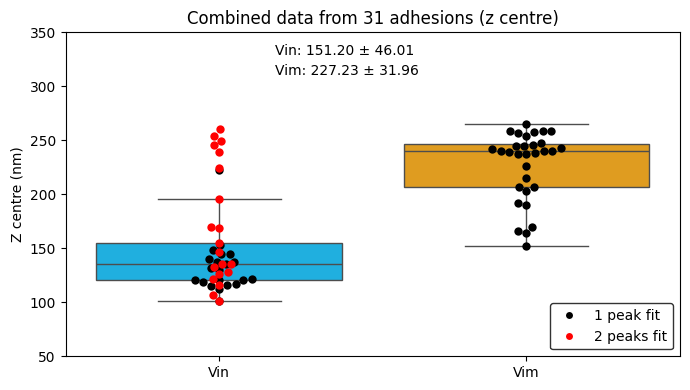

In [338]:

plt.figure(figsize=(7, 4))
ax = plt.axes()

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

# Boxplot for background distribution
sns.boxplot(x='Channel', y='Z Center Value', data=combined_data, hue='Channel', palette=['#00bfff', '#ffa500'], showfliers=False)

colors = ['black', 'red'] 
for color in colors:
    subset = combined_data[(combined_data['Channel'] == 'ch1') & (combined_data['Color'] == color)]
    if not subset.empty:
        sns.swarmplot(x='Channel', y='Z Center Value', data=subset, color=color, size=6)

# CH2 data
subset = combined_data[combined_data['Channel'] == 'ch2']    
if not subset.empty:
    sns.swarmplot(x='Channel', y='Z Center Value', data=subset, color='black', size=6)

new_labels = ch_name
plt.xticks(ticks=[0, 1], labels=new_labels)

# Annotations for mean ± SD
plt.figtext(0.4, 0.85, f'{ch_name[0]}: {ch1_mean:.2f} ± {ch1_sd:.2f}', ha='left', color='black', fontsize=10, backgroundcolor='white')
plt.figtext(0.4, 0.8, f'{ch_name[1]}: {ch2_mean:.2f} ± {ch2_sd:.2f}', ha='left', color='black', fontsize=10, backgroundcolor='white')
plt.title('Combined data from '+str(len(final_df['ROI_ind']))+ ' adhesions (z centre)')
plt.xlabel('')
plt.ylabel('Z centre (nm)')
plt.ylim(50,350)

# Custom legend for pick_mode and ch2
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='1 peak fit', markerfacecolor='black', markersize=6),
    Line2D([0], [0], marker='o', color='w', label='2 peaks fit', markerfacecolor='red', markersize=6),
    # Uncomment the following line if you want to include CH2 in the legend
    # Line2D([0], [0], marker='o', color='w', label='CH2', markerfacecolor='black', markersize=10)
]

plt.legend(handles=legend_elements, loc='lower right', edgecolor='black')

plt.grid(False)
plt.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)

plt.tight_layout()

plt.savefig(parent_dir_output + "//summarised_2ch_2peak Fit_cell20_swarmplot.png", dpi=300)
print('Results are saved to the folder:', parent_dir_output)
plt.show()


## Analysis when  1 pick fit was used
Can be run separatelly 

In [339]:
%reset -f
import seaborn as sns
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


In [340]:
parent_dir_output = "/Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/cell_x20" 
file_output = "output_data.txt"
file_output_2pick="output_data_2_peak.txt"
output_full_df = "output_z_700nm.txt"
output_path = os.path.join(parent_dir_output, file_output)
output_path_full_df = os.path.join(parent_dir_output, output_full_df)
output_path_full_2pick = os.path.join(parent_dir_output, file_output_2pick) 
full_output_folder = parent_dir_output
ch_name = ["Vin","Vim"]

In [341]:
# Load the data nto data frame from the first file where the results in the format  
# ROI_ind,z_center_ch1,sd_ch1,z_center_ch2,sd_ch2,downsampling,pick_mode
final_df_1_peak  = pd.read_csv(output_path) 

Results are saved to the folder: /Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/cell_x20


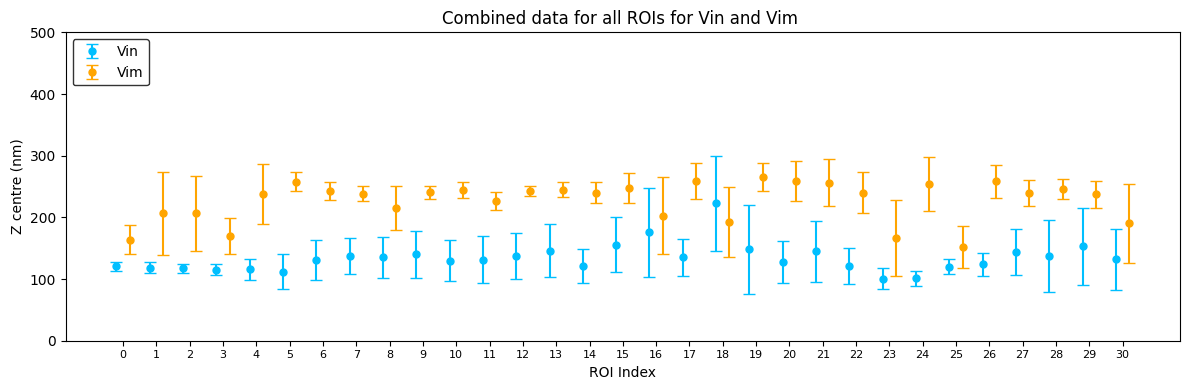

In [342]:
x_values = np.arange(len(final_df_1_peak ))

offset_ch1 = -0.2  
offset_ch2 = 0.2   

plt.figure(figsize=(12, 4))
ax = plt.axes()

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.errorbar(x_values + offset_ch1, final_df_1_peak ['z_center_ch1'], yerr=final_df_1_peak ['sd_ch1'], fmt='o', color='#00bfff', capsize=4, markersize='5', label=ch_name[0]) 
ax.errorbar(x_values + offset_ch2, final_df_1_peak ['z_center_ch2'], yerr=final_df_1_peak ['sd_ch2'], fmt='o', color='#ffa500', capsize=4, markersize='5', label=ch_name[1])

plt.xlabel('ROI Index')
plt.ylabel('Z centre (nm)')
plt.title('Combined data for all ROIs for Vin and Vim ')
plt.xticks(x_values, [ind.split('_')[1] for ind in final_df_1_peak ['ROI_ind'].astype(str)], rotation=0, size=8) 
plt.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)
legend = plt.legend(loc='upper left')
frame = legend.get_frame()
frame.set_edgecolor('black')
#frame.set_linewidth(2)
plt.grid(False)
plt.tight_layout()
plt.ylim(0,500)
plt.savefig(parent_dir_output+ "//allRois_2ch_with_1pickFitting_cell20.png",dpi=300)
print('Results are saved to the folder:', parent_dir_output)
plt.show()


Results are saved to the folder: /Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/cell_x20


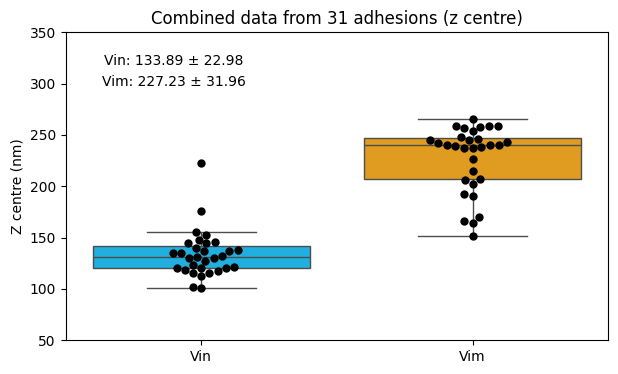

In [343]:
import seaborn as sns
y1 = final_df_1_peak ['z_center_ch1']
y2 = final_df_1_peak ['z_center_ch2']

df = pd.DataFrame({'Channel': [ch_name[0]] * len(y1) + [ch_name[1]] * len(y2),
                   'Values': np.concatenate([y1, y2])})

means = df.groupby('Channel')['Values'].mean()
std_devs = df.groupby('Channel')['Values'].std()

# Create a boxplot with data points
plt.figure(figsize=(7, 4))
ax = plt.axes()

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')


box = sns.boxplot(x='Channel', y='Values', data=df, showfliers=False, hue='Channel', palette={ch_name[0]: '#00bfff', ch_name[1]: '#ffa500'})  # Set showfliers to True if you want to display outliers
swarm = sns.swarmplot(x='Channel', y='Values', data=df, color="black", size=6)  # Add swarmplot for data points
plt.title('Combined data from '+str(len(y1)) + ' adhesions (z centre)')
plt.xlabel('')
plt.ylabel('Z centre (nm)')

# Print the mean ± standard deviation
res_Vin= f"{ch_name[0]}: {means[ch_name[0]]:.2f} ± {std_devs[ch_name[0]]:.2f}"
res_Vim= f"{ch_name[1]}: {means[ch_name[1]]:.2f} ± {std_devs[ch_name[1]]:.2f}"

plt.ylim(50,350)
plt.text(-0.1, max(df['Values']+50) , res_Vin, ha='center', va='bottom',size=10)
plt.text(-0.1, max(df['Values']+30) , res_Vim, ha='center', va='bottom',size=10)

plt.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)

plt.grid(False)

plt.savefig(parent_dir_output+ "//summarised_2ch_1peak Fit_cell20.png", dpi=300)
print('Results are saved to the folder:', parent_dir_output)
plt.show()


## Cell 21

In [344]:
%reset -f
import seaborn as sns
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


In [345]:
parent_dir_output = "/Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/cell_x21" 
file_output = "output_data.txt"
file_output_2pick="output_data_2_peak.txt"
output_full_df = "output_z_700nm.txt"
output_path = os.path.join(parent_dir_output, file_output)
output_path_full_df = os.path.join(parent_dir_output, output_full_df)
output_path_full_2pick = os.path.join(parent_dir_output, file_output_2pick) 
full_output_folder = parent_dir_output
ch_name = ["Vin","Vim"]

## Analysis with 2 pick data

In [346]:

# Load the data nto data frame from the first file where the results in the format  file just with ROI_ind,z_center_ch1,sd_ch1,z_center_ch2,sd_ch2,downsampling,pick_mode
df1 = pd.read_csv(output_path) 

# Load the data for ROIs with pick_mode=2 in the format  file just with ROI_ind,z_center_ch1,sd_ch1,z_center_ch2,sd_ch2,downsampling,pick_mode

df2 = pd.read_csv(output_path_full_2pick )

# Merge the dataframes on 'ROI_ind'(put 'outer' so all rows are included, even if they don't have a match in the other dataframe )

final_df = pd.merge(df1, df2, on='ROI_ind', how='outer')

# To select the some fields for the final table
final_columns = ['ROI_ind', 'z_center_ch1', 'sd_ch1', 'z_center_ch2', 'sd_ch2', 'downsampling', 'pick_mode', 'z_center_ch1_p1', 'sd_ch1_p1', 'z_center_ch1_p2', 'sd_ch1_p2']

final_df = final_df[final_columns] #main data frame to work with 

# Fill NaN values, remember to work on them later maybe
final_df.fillna(np.nan, inplace=True)

#Let's sort it as well
final_df['ROI_index'] = final_df['ROI_ind'].str.extract(r'(\d+)').astype(int)
sorted_df = final_df.sort_values('ROI_index').drop(columns='ROI_index')
sorted_df.reset_index(drop=True, inplace=True) # to update row index 
final_df = sorted_df
# Save the final dataframe to a new CSV file 
final_df.to_csv(full_output_folder+'///final_table.csv', index=False)
print(full_output_folder)

/Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/cell_x21


Results are saved to the folder: /Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/cell_x21


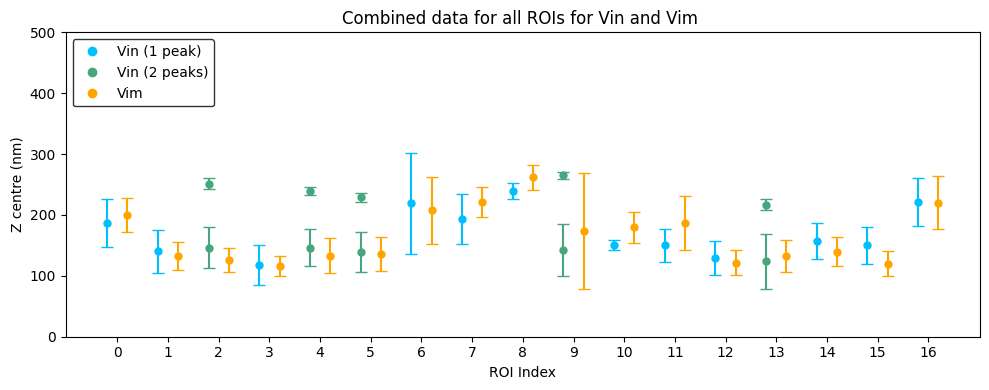

In [347]:
x_values = np.arange(len(final_df))

offset_ch1 = -0.2  
offset_ch2 = 0.2   

plt.figure(figsize=(10, 4))
ax = plt.axes()

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

# To ensure legends are correctly added once for each type
legend_added_for_pick_mode_2 = False

# Vin data plot
for i, row in final_df.iterrows():
    x_base = x_values[i]  # Base x-coord for this ROI
    if row['pick_mode'] == 2:
        # For pick_mode=2, plot both p1 and p2 
        plt.errorbar(x_base + offset_ch1, row['z_center_ch1_p1'], yerr=row['sd_ch1_p1'], fmt='o', markersize='5', color='#47a67e', capsize=4, label=(ch_name[0]+'2 picks') if not legend_added_for_pick_mode_2 else "")
        plt.errorbar(x_base + offset_ch1, row['z_center_ch1_p2'], yerr=row['sd_ch1_p2'], fmt='o', color='#47a67e',markersize='5', capsize=4, label=(ch_name[0]+'2 picks') if not legend_added_for_pick_mode_2 else "")
        legend_added_for_pick_mode_2 = True
    else:
        # For other cases, plot the standard values for Vin  
        plt.errorbar(x_base + offset_ch1, row['z_center_ch1'], yerr=row['sd_ch1'], fmt='o', color='#00bfff', markersize='5',capsize=4, label='Channel 1' if i == 0 else "")
plt.errorbar(x_values + offset_ch2, final_df['z_center_ch2'], yerr=final_df['sd_ch2'], fmt='o', color='#ffa500',markersize='5', capsize=4, label=ch_name[1])

plt.xlabel('ROI Index')
plt.ylabel('Z centre (nm)')
plt.title('Combined data for all ROIs for Vin and Vim ')
plt.xticks(x_values, [ind.split('_')[1] for ind in final_df['ROI_ind'].astype(str)], rotation=0) 
plt.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)
legend_elements = [
    Line2D([0], [0], color='#00bfff', marker='o', linestyle='None', label=ch_name[0]+' (1 peak)'),
    Line2D([0], [0], color='#47a67e', marker='o', linestyle='None', label=(ch_name[0]+' (2 peaks)')),
    Line2D([0], [0], color='#ffa500', marker='o', linestyle='None', label=ch_name[1])
]
plt.legend(handles=legend_elements,loc='upper left',edgecolor='black')
plt.ylim(0,500)
plt.grid(False)
plt.tight_layout()
plt.savefig(parent_dir_output+ "//allRois_2ch_with_2pickFitting_cell21.png",dpi=300)
print('Results are saved to the folder:', parent_dir_output)
plt.show()


In [348]:
# Processing to select data based on conditions
def select_data(row):
    if row['pick_mode'] == 2:
        # For pick_mode=2, select both z_center_ch1_p1 and z_center_ch1_p2
        return pd.Series([row['z_center_ch1_p1'], row['z_center_ch1_p2']])
    else:
        # Otherwise, select z_center_ch1
        return pd.Series([row['z_center_ch1'], pd.NA])

# Apply the function and create a new DataFrame with the selected data
selected_data_ch1 = final_df.apply(select_data, axis=1)
selected_data_ch1.columns = ['z_center_selected', 'z_center_selected_p2']

# Combine with ROI_ind for clarity
selected_data = pd.concat([final_df['ROI_ind'], selected_data_ch1, final_df['pick_mode'], final_df['z_center_ch2']], axis=1)
print(selected_data)


   ROI_ind  z_center_selected z_center_selected_p2  pick_mode  z_center_ch2
0    ROI_0             187.37                 <NA>          1        199.97
1    ROI_1             140.04                 <NA>          1        132.82
2    ROI_2             146.34                251.3          2        125.87
3    ROI_3             118.37                 <NA>          1        116.23
4    ROI_4             145.90               238.89          2        133.20
5    ROI_5             139.72               228.92          2        136.08
6    ROI_6             219.24                 <NA>          1        207.73
7    ROI_7             193.91                 <NA>          1        220.96
8    ROI_8             239.47                 <NA>          1        262.06
9    ROI_9             142.69               265.26          2        173.67
10  ROI_10             150.76                 <NA>          1        179.72
11  ROI_11             150.25                 <NA>          1        186.49
12  ROI_12  

In [349]:
ch1_data = pd.melt(selected_data, id_vars=['ROI_ind', 'pick_mode'], 
                   value_vars=['z_center_selected', 'z_center_selected_p2'],
                   var_name='Measurement Type', value_name='Z Center Value').dropna()


ch2_data = selected_data[['ROI_ind', 'z_center_ch2']].copy()
ch2_data['Z Center Value'] = ch2_data['z_center_ch2']
ch2_data['Channel'] = 'ch2'

combined_data = pd.concat([ch1_data.drop(columns=['Measurement Type']), ch2_data.drop(columns=['z_center_ch2'])])
combined_data['Channel'] = combined_data.apply(lambda x: 'ch1' if pd.notnull(x['pick_mode']) else 'ch2', axis=1)
combined_data['Color'] = combined_data.apply(lambda x: 'red' if x['pick_mode'] == 2 else 'black', axis=1)


ch1_mean = combined_data[combined_data['Channel'] == 'ch1']['Z Center Value'].mean()
ch1_sd = combined_data[combined_data['Channel'] == 'ch1']['Z Center Value'].std()

ch2_mean = combined_data[combined_data['Channel'] == 'ch2']['Z Center Value'].mean()
ch2_sd = combined_data[combined_data['Channel'] == 'ch2']['Z Center Value'].std()
print(combined_data.info())
print(ch1_mean )

<class 'pandas.core.frame.DataFrame'>
Index: 39 entries, 0 to 16
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ROI_ind         39 non-null     object 
 1   pick_mode       22 non-null     float64
 2   Z Center Value  39 non-null     object 
 3   Channel         39 non-null     object 
 4   Color           39 non-null     object 
dtypes: float64(1), object(4)
memory usage: 1.8+ KB
None
179.90136363636364


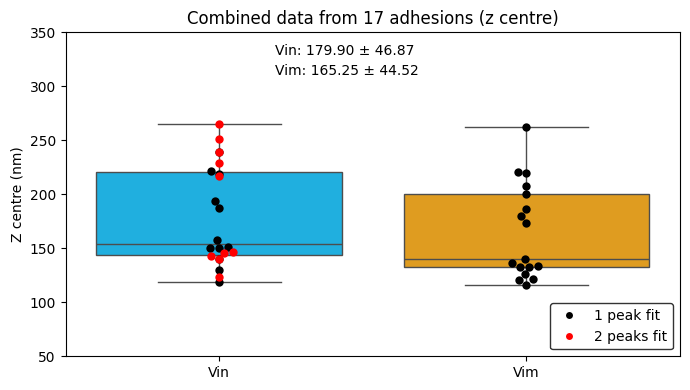

In [350]:
plt.figure(figsize=(7, 4))
ax = plt.axes()

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

# Boxplot for background distribution
sns.boxplot(x='Channel', y='Z Center Value', data=combined_data, hue='Channel', palette=['#00bfff', '#ffa500'], showfliers=False)

colors = ['black', 'red'] 
for color in colors:
    subset = combined_data[(combined_data['Channel'] == 'ch1') & (combined_data['Color'] == color)]
    if not subset.empty:
        sns.swarmplot(x='Channel', y='Z Center Value', data=subset, color=color, size=6)

# CH2 data
subset = combined_data[combined_data['Channel'] == 'ch2']    
if not subset.empty:
    sns.swarmplot(x='Channel', y='Z Center Value', data=subset, color='black', size=6)

new_labels = ch_name
plt.xticks(ticks=[0, 1], labels=new_labels)

# Annotations for mean ± SD
plt.figtext(0.4, 0.85, f'{ch_name[0]}: {ch1_mean:.2f} ± {ch1_sd:.2f}', ha='left', color='black', fontsize=10, backgroundcolor='white')
plt.figtext(0.4, 0.8, f'{ch_name[1]}: {ch2_mean:.2f} ± {ch2_sd:.2f}', ha='left', color='black', fontsize=10, backgroundcolor='white')
plt.title('Combined data from '+str(len(final_df['ROI_ind']))+ ' adhesions (z centre)')
plt.xlabel('')
plt.ylabel('Z centre (nm)')
plt.ylim(50,350)

# Custom legend for pick_mode and ch2
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='1 peak fit', markerfacecolor='black', markersize=6),
    Line2D([0], [0], marker='o', color='w', label='2 peaks fit', markerfacecolor='red', markersize=6),
    # Uncomment the following line if you want to include CH2 in the legend
    # Line2D([0], [0], marker='o', color='w', label='CH2', markerfacecolor='black', markersize=10)
]

plt.legend(handles=legend_elements, loc='lower right', edgecolor='black')

plt.grid(False)
plt.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)

plt.tight_layout()

plt.savefig(parent_dir_output + "//summarised_2ch_2peak Fit_cell21_swarmplot.png", dpi=300)
plt.show()


## Analysis when  1 pick data was used

In [351]:
%reset -f
import seaborn as sns
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
ch_name = ["Vin","Vim"]

In [352]:
parent_dir_output = "/Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/cell_x21" 
file_output = "output_data.txt"
file_output_2pick="output_data_2_peak.txt"
output_full_df = "output_z_700nm.txt"
output_path = os.path.join(parent_dir_output, file_output)
output_path_full_df = os.path.join(parent_dir_output, output_full_df)
output_path_full_2pick = os.path.join(parent_dir_output, file_output_2pick) 
full_output_folder = parent_dir_output
ch_name = ["Vin","Vim"]

In [353]:
# Load the data nto data frame from the first file where the results in the format  
# ROI_ind,z_center_ch1,sd_ch1,z_center_ch2,sd_ch2,downsampling,pick_mode
final_df_1_peak  = pd.read_csv(output_path) 

Results are saved to the folder: /Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/cell_x21


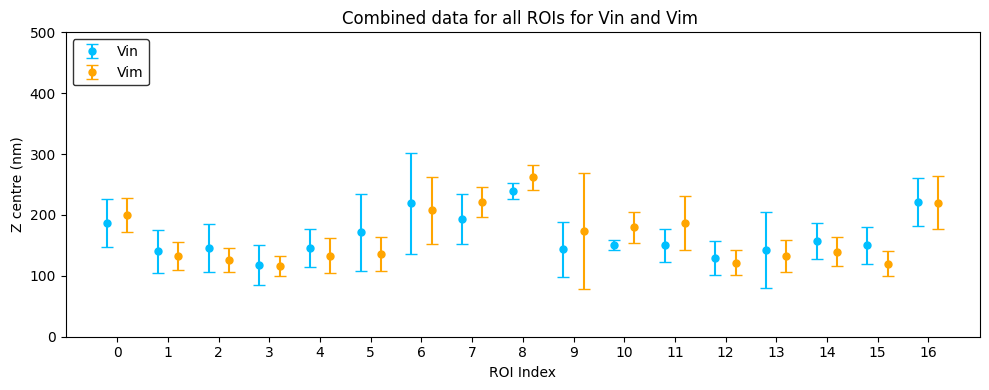

In [354]:

x_values = np.arange(len(final_df_1_peak ))

offset_ch1 = -0.2  
offset_ch2 = 0.2   

plt.figure(figsize=(10, 4))
ax = plt.axes()

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.errorbar(x_values + offset_ch1, final_df_1_peak ['z_center_ch1'], markersize='5',yerr=final_df_1_peak ['sd_ch1'], fmt='o', color='#00bfff', capsize=4, label=ch_name[0]) 
ax.errorbar(x_values + offset_ch2, final_df_1_peak ['z_center_ch2'],markersize='5', yerr=final_df_1_peak ['sd_ch2'], fmt='o', color='#ffa500', capsize=4, label=ch_name[1])

plt.xlabel('ROI Index')
plt.ylabel('Z centre (nm)')
plt.title('Combined data for all ROIs for Vin and Vim ')
plt.xticks(x_values, [ind.split('_')[1] for ind in final_df_1_peak['ROI_ind'].astype(str)], rotation=0) 
plt.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)
legend = plt.legend(loc='upper left')
frame = legend.get_frame()
frame.set_edgecolor('black')
#frame.set_linewidth(2)
plt.grid(False)
plt.tight_layout()
plt.ylim(0,500)
plt.savefig(parent_dir_output+ "//allRois_2ch_with_1pickFitting_cell21.png",dpi=300)
print('Results are saved to the folder:', parent_dir_output)
plt.show()


Results are saved to the folder: /Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/cell_x21


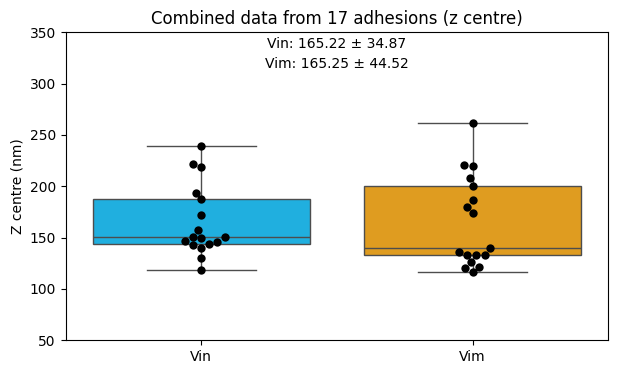

In [355]:
import seaborn as sns
y1 = final_df_1_peak ['z_center_ch1']
y2 = final_df_1_peak ['z_center_ch2']

df = pd.DataFrame({'Channel': [ch_name[0]] * len(y1) + [ch_name[1]] * len(y2),
                   'Values': np.concatenate([y1, y2])})

means = df.groupby('Channel')['Values'].mean()
std_devs = df.groupby('Channel')['Values'].std()

# Create a boxplot with data points
plt.figure(figsize=(7, 4))
ax = plt.axes()

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')


box = sns.boxplot(x='Channel', y='Values', data=df, showfliers=False, hue='Channel', palette={ch_name[0]: '#00bfff', ch_name[1]: '#ffa500'})  # Set showfliers to True if you want to display outliers
swarm = sns.swarmplot(x='Channel', y='Values', data=df, color="black", size=6)  # Add swarmplot for data points
plt.title('Combined data from '+str(len(y1)) + ' adhesions (z centre)')
plt.xlabel('')
plt.ylabel('Z centre (nm)')

# Print the mean ± standard deviation
res_Vin= f"{ch_name[0]}: {means[ch_name[0]]:.2f} ± {std_devs[ch_name[0]]:.2f}"
res_Vim= f"{ch_name[1]}: {means[ch_name[1]]:.2f} ± {std_devs[ch_name[1]]:.2f}"

plt.ylim(50,350)
plt.text(0.5, max(df['Values']+70) , res_Vin, ha='center', va='bottom',size=10)
plt.text(0.5, max(df['Values']+50) , res_Vim, ha='center', va='bottom',size=10)

plt.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)

plt.grid(False)

plt.savefig(parent_dir_output+ "//summarised_2ch_1peak Fit_cell21.png", dpi=300)
print('Results are saved to the folder:', parent_dir_output)
plt.show()


## Repeat for each cell 

## ALL files togeter

In [368]:
%reset -f
import seaborn as sns
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


In [369]:
output_file_cell20 = "/Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/cell_x20////final_table.csv" 
output_file_cell21 = "/Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/cell_x21////final_table.csv" 
output_file_cell25 = "/Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/cell_x25////final_table.csv" 
parent_dir_output = '//Users//Elena//Documents//Arun_2023//TXT_STORY//NY_2024'
ch_name = ["Vin","Vim"]
parent_dir_output = '/Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024'

In [370]:
df_20 = pd.read_csv(output_file_cell20)
df_20['ROI_index'] = df_20['ROI_ind'].str.extract('(\d+)').astype(int)
df_20_sorted = df_20.sort_values(by='ROI_index').drop(columns='ROI_index')
df_20=df_20_sorted

df_21 = pd.read_csv(output_file_cell21)
#to sort
df_21['ROI_index'] = df_21['ROI_ind'].str.extract('(\d+)').astype(int)
df_21_sorted = df_21.sort_values(by='ROI_index').drop(columns='ROI_index')
df_21=df_21_sorted


df_combined_20_21 = pd.concat([df_20, df_21], ignore_index=True)
df_25 = pd.read_csv(output_file_cell25)
df_combined_all = pd.concat([df_combined_20_21, df_25], ignore_index=True)


df_combined_20_21.to_csv(parent_dir_output+'//output_fin//final_table20_21.csv', index=False)
df_combined_all.to_csv(parent_dir_output+'//output_fin//final_table_all.csv', index=False)
#df_combined_all['ROI_new_ind'] = ['ROI_' + str(i+1) for i in range(len(df_combined_all))]


df_combined_all['ROI_new_ind']=df_combined_all['ROI_ind'] 


In [371]:
df_21

,ROI_ind,z_center_ch1,sd_ch1,z_center_ch2,sd_ch2,downsampling,pick_mode,z_center_ch1_p1,sd_ch1_p1,z_center_ch1_p2,sd_ch1_p2
0,ROI_0,187.37,39.23,199.97,27.34,1,1,NaN,NaN,NaN,NaN
1,ROI_1,140.04,35.77,132.82,23.15,0,1,NaN,NaN,NaN,NaN
2,ROI_2,146.29,39.44,125.87,20.37,0,2,146.34,33.41,251.30,9.35
3,ROI_3,118.37,32.70,116.23,16.39,0,1,NaN,NaN,NaN,NaN
4,ROI_4,146.17,31.35,133.20,28.50,0,2,145.90,30.46,238.89,6.61
5,ROI_5,171.67,62.94,136.08,27.58,0,2,139.72,32.74,228.92,7.75
6,ROI_6,219.24,83.28,207.73,55.17,1,1,NaN,NaN,NaN,NaN
7,ROI_7,193.91,40.81,220.96,24.86,1,1,NaN,NaN,NaN,NaN
8,ROI_8,239.47,12.56,262.06,20.73,0,1,NaN,NaN,NaN,NaN
9,ROI_9,143.90,45.06,173.67,95.57,1,2,142.69,42.31,265.26,6.13


## Analysis with 2 pick data

Results are saved to the folder: /Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024


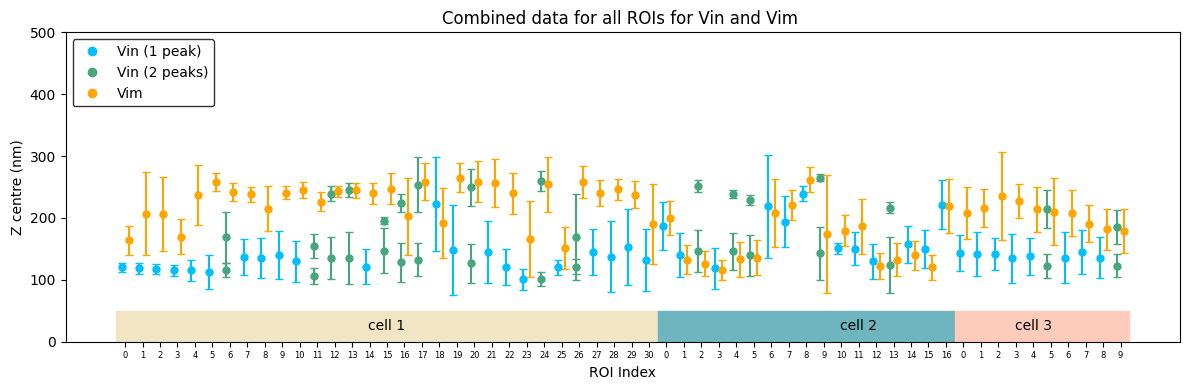

In [372]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D
import seaborn as sns

final_df = df_combined_all
x_values = np.arange(len(final_df))

offset_ch1 = -0.2  
offset_ch2 = 0.2   

plt.figure(figsize=(12, 4))
ax = plt.axes()

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

legend_added_for_pick_mode_2 = False

for i, row in final_df.iterrows():
    x_base = x_values[i]  
    if row['pick_mode'] == 2:
        plt.errorbar(x_base + offset_ch1, row['z_center_ch1_p1'], yerr=row['sd_ch1_p1'], fmt='o', color='#47a67e',markersize='5', capsize=3, label=(ch_name[0]+'2 picks') if not legend_added_for_pick_mode_2 else "")
        plt.errorbar(x_base + offset_ch1, row['z_center_ch1_p2'], yerr=row['sd_ch1_p2'], fmt='o', color='#47a67e', capsize=3,markersize='5', label=(ch_name[0]+'2 picks') if not legend_added_for_pick_mode_2 else "")
        legend_added_for_pick_mode_2 = True
    else:
        plt.errorbar(x_base + offset_ch1, row['z_center_ch1'], yerr=row['sd_ch1'], fmt='o', markersize='5',color='#00bfff', capsize=3, label='Channel 1' if i == 0 else "")
plt.errorbar(x_values + offset_ch2, final_df['z_center_ch2'], yerr=final_df['sd_ch2'], fmt='o', color='#ffa500', capsize=3, label=ch_name[1],markersize='5')

plt.xlabel('ROI Index')
plt.ylabel('Z centre (nm)')
plt.title('Combined data for all ROIs for Vin and Vim ')
plt.xticks(x_values, [ind.split('_')[1] for ind in final_df['ROI_new_ind'].astype(str)], size=6) 
plt.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)

legend_elements = [
    Line2D([0], [0], color='#00bfff', marker='o', linestyle='None', label=(ch_name[0]+' (1 peak)')),
    Line2D([0], [0], color='#47a67e', marker='o', linestyle='None', label=(ch_name[0]+' (2 peaks)')),
    Line2D([0], [0], color='#ffa500', marker='o', linestyle='None', label=ch_name[1])
]
plt.legend(handles=legend_elements, loc='upper left', edgecolor='black')
plt.ylim(0, 500)
plt.grid(False)
x

plt.fill_betweenx([0, 50], -0.5, (len(df_20['ROI_ind'])-0.5), color='#F1E5C4', alpha=1)
plt.fill_betweenx([0, 50], (len(df_20['ROI_ind'])-0.5), (len(df_20['ROI_ind'])-0.5)+(len(df_21['ROI_ind'])), color='#6EB5C0', alpha=1)
plt.fill_betweenx([0, 50], (len(df_20['ROI_ind']))+(len(df_21['ROI_ind'])-0.5), (len(df_20['ROI_ind']))+(len(df_21['ROI_ind']))+(len(df_25['ROI_ind'])-0.5), color='#FFCCBB', alpha=1)

plt.text(15, 25, 'cell 1', horizontalalignment='center', verticalalignment='center', fontsize=10, color='black')
plt.text(42, 25, 'cell 2', horizontalalignment='center', verticalalignment='center', fontsize=10, color='black')
plt.text(52, 25, 'cell 3', horizontalalignment='center', verticalalignment='center', fontsize=10, color='black')
plt.tight_layout()
plt.savefig(parent_dir_output + "/allRois_2ch_with_2pickFitting_all.png", dpi=300)
print('Results are saved to the folder:', parent_dir_output)

plt.show()


In [373]:
df_combined_all

,ROI_ind,z_center_ch1,sd_ch1,z_center_ch2,sd_ch2,downsampling,pick_mode,z_center_ch1_p1,sd_ch1_p1,z_center_ch1_p2,sd_ch1_p2,ROI_new_ind
0,ROI_0,120.63,7.33,164.03,23.61,0,1,NaN,NaN,NaN,NaN,ROI_0
1,ROI_1,118.50,9.24,206.98,67.20,0,1,NaN,NaN,NaN,NaN,ROI_1
2,ROI_2,117.23,7.66,206.48,60.45,0,1,NaN,NaN,NaN,NaN,ROI_2
3,ROI_3,115.33,8.43,169.76,28.56,0,1,NaN,NaN,NaN,NaN,ROI_3
4,ROI_4,115.78,16.99,237.14,48.69,0,1,NaN,NaN,NaN,NaN,ROI_4
5,ROI_5,112.16,27.72,258.11,15.18,0,1,NaN,NaN,NaN,NaN,ROI_5
6,ROI_6,130.52,32.54,242.38,14.39,1,2,116.26,11.31,168.62,41.64,ROI_6
7,ROI_7,136.86,29.00,238.42,11.98,0,1,NaN,NaN,NaN,NaN,ROI_7
8,ROI_8,135.02,32.61,215.21,35.66,0,1,NaN,NaN,NaN,NaN,ROI_8
9,ROI_9,140.15,38.47,240.53,10.66,0,1,NaN,NaN,NaN,NaN,ROI_9


In [374]:
# Processing to select data based on conditions
def select_data(row):
    if row['pick_mode'] == 2:
        # for pick_mode=2, select both z_center_ch1_p1 and z_center_ch1_p2
        return pd.Series([row['z_center_ch1_p1'], row['z_center_ch1_p2']])
    else:
        # select z_center_ch1
        return pd.Series([row['z_center_ch1'], pd.NA])

# Apply the function 
selected_data_ch1 = final_df.apply(select_data, axis=1)
selected_data_ch1.columns = ['z_center_selected', 'z_center_selected_p2']

selected_data = pd.concat([final_df['ROI_ind'], selected_data_ch1, final_df['pick_mode'], final_df['z_center_ch2']], axis=1)
print(selected_data)


   ROI_ind  z_center_selected z_center_selected_p2  pick_mode  z_center_ch2
0    ROI_0             120.63                 <NA>          1        164.03
1    ROI_1             118.50                 <NA>          1        206.98
2    ROI_2             117.23                 <NA>          1        206.48
3    ROI_3             115.33                 <NA>          1        169.76
4    ROI_4             115.78                 <NA>          1        237.14
5    ROI_5             112.16                 <NA>          1        258.11
6    ROI_6             116.26               168.62          2        242.38
7    ROI_7             136.86                 <NA>          1        238.42
8    ROI_8             135.02                 <NA>          1        215.21
9    ROI_9             140.15                 <NA>          1        240.53
10  ROI_10             129.78                 <NA>          1        245.05
11  ROI_11             106.50               155.35          2        226.61
12  ROI_12  

In [375]:
ch1_data = pd.melt(selected_data, id_vars=['ROI_ind', 'pick_mode'], 
                   value_vars=['z_center_selected', 'z_center_selected_p2'],
                   var_name='Measurement Type', value_name='Z Center Value').dropna()


ch2_data = selected_data[['ROI_ind', 'z_center_ch2']].copy()
ch2_data['Z Center Value'] = ch2_data['z_center_ch2']
ch2_data['Channel'] = 'ch2'

combined_data = pd.concat([ch1_data.drop(columns=['Measurement Type']), ch2_data.drop(columns=['z_center_ch2'])])
combined_data['Channel'] = combined_data.apply(lambda x: 'ch1' if pd.notnull(x['pick_mode']) else 'ch2', axis=1)
combined_data['Color'] = combined_data.apply(lambda x: 'red' if x['pick_mode'] == 2 else 'black', axis=1)


ch1_mean = combined_data[combined_data['Channel'] == 'ch1']['Z Center Value'].mean()
ch1_sd = combined_data[combined_data['Channel'] == 'ch1']['Z Center Value'].std()

ch2_mean = combined_data[combined_data['Channel'] == 'ch2']['Z Center Value'].mean()
ch2_sd = combined_data[combined_data['Channel'] == 'ch2']['Z Center Value'].std()
print(combined_data.info())
print(ch1_mean )

<class 'pandas.core.frame.DataFrame'>
Index: 133 entries, 0 to 57
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ROI_ind         133 non-null    object 
 1   pick_mode       75 non-null     float64
 2   Z Center Value  133 non-null    object 
 3   Channel         133 non-null    object 
 4   Color           133 non-null    object 
dtypes: float64(1), object(4)
memory usage: 6.2+ KB
None
158.93240000000003


Results are saved to the folder: /Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024


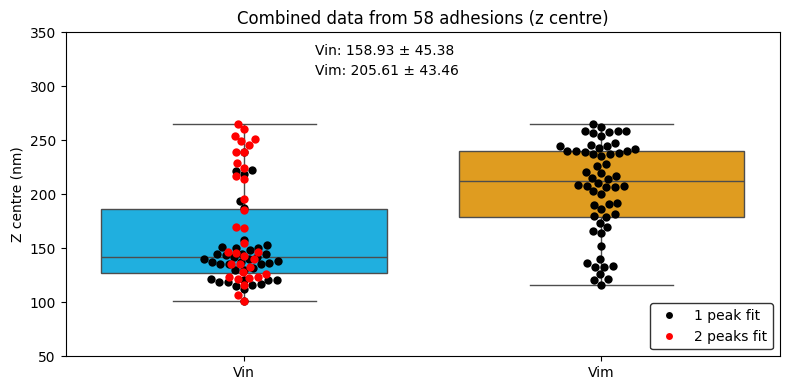

In [376]:

plt.figure(figsize=(8, 4))
ax = plt.axes()

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

sns.boxplot(x='Channel', y='Z Center Value', data=combined_data, hue='Channel', palette=['#00bfff', '#ffa500'], showfliers=False)


colors = ['black', 'red']  # Define colors explicitly if needed
for color in colors:
    subset = combined_data[(combined_data['Channel'] == 'ch1') & (combined_data['Color'] == color)]
    if not subset.empty:
        sns.swarmplot(x='Channel', y='Z Center Value', data=subset, color=color, size=6)

# CH2 data
subset = combined_data[combined_data['Channel'] == 'ch2']    
if not subset.empty:
    sns.swarmplot(x='Channel', y='Z Center Value', data=subset, color='black', size=6)

new_labels = ch_name
plt.xticks(ticks=[0, 1], labels=new_labels)

# Annotations 
plt.figtext(0.4, 0.85, f'{ch_name[0]}: {ch1_mean:.2f} ± {ch1_sd:.2f}', ha='left', color='black', fontsize=10, backgroundcolor='white')
plt.figtext(0.4, 0.8, f'{ch_name[1]}: {ch2_mean:.2f} ± {ch2_sd:.2f}', ha='left', color='black', fontsize=10, backgroundcolor='white')
plt.title('Combined data from '+str(len(final_df['ROI_ind']))+ ' adhesions (z centre)')
plt.xlabel('')
plt.ylabel('Z centre (nm)')
plt.ylim(50,350)


legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='1 peak fit', markerfacecolor='black', markersize=6),
    Line2D([0], [0], marker='o', color='w', label='2 peaks fit', markerfacecolor='red', markersize=6),
    # Uncomment the following line if you want to include CH2 in the legend
    # Line2D([0], [0], marker='o', color='w', label='CH2', markerfacecolor='black', markersize=10)
]

plt.legend(handles=legend_elements, loc='lower right', edgecolor='black')

plt.grid(False)
plt.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)

plt.tight_layout()

plt.savefig(parent_dir_output + "//summarised_2ch_2peak Fit_all_swarmplot.png", dpi=300)
print('Results are saved to the folder:', parent_dir_output)
plt.show()


## Analysis when  1 pick data was used

In [1]:
final_df_1_peak =df_combined_all
x_values = np.arange(len(final_df_1_peak ))

offset_ch1 = -0.2  
offset_ch2 = 0.2   

plt.figure(figsize=(12, 4))
ax = plt.axes()

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.errorbar(x_values + offset_ch1, final_df_1_peak['z_center_ch1'], yerr=final_df_1_peak['sd_ch1'], 
            fmt='o', color=(0, 191/255, 1), capsize=3, label=ch_name[0], markersize='5')

#ax.errorbar(x_values + offset_ch1, final_df_1_peak ['z_center_ch1'], yerr=final_df_1_peak ['sd_ch1'], fmt='o', color='#00bfff', capsize=3, label=ch_name[0],markersize='5') 
ax.errorbar(x_values + offset_ch2, final_df_1_peak ['z_center_ch2'], yerr=final_df_1_peak ['sd_ch2'], fmt='o', color='#ffa500', capsize=3, label=ch_name[1],markersize='5')

plt.xlabel('ROI Index')
plt.ylabel('Z centre (nm)')
plt.title('Combined data for all ROIs for Vin and Vim ')
plt.xticks(x_values, [ind.split('_')[1] for ind in final_df['ROI_new_ind'].astype(str)], rotation=0, size=6) 
plt.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)
legend = plt.legend(loc='upper left')
frame = legend.get_frame()
frame.set_edgecolor('black')
#frame.set_linewidth(2)
plt.grid(False)
plt.tight_layout()
plt.ylim(0,500)

plt.fill_betweenx([0, 50], -0.5, (len(df_20['ROI_ind'])-0.5), color='#F1E5C4', alpha=1)
plt.fill_betweenx([0, 50], (len(df_20['ROI_ind'])-0.5), (len(df_20['ROI_ind'])-0.5)+(len(df_21['ROI_ind'])), color='#6EB5C0', alpha=1)
plt.fill_betweenx([0, 50], (len(df_20['ROI_ind']))+(len(df_21['ROI_ind'])-0.5), (len(df_20['ROI_ind']))+(len(df_21['ROI_ind']))+(len(df_25['ROI_ind'])-0.5), color='#FFCCBB', alpha=1)

plt.text(15, 25, 'cell 1', horizontalalignment='center', verticalalignment='center', fontsize=10, color='black')
plt.text(42, 25, 'cell 2', horizontalalignment='center', verticalalignment='center', fontsize=10, color='black')
plt.text(52, 25, 'cell 3', horizontalalignment='center', verticalalignment='center', fontsize=10, color='black')


plt.savefig(parent_dir_output+ "//allRois_2ch_with_1pickFitting_all.png",dpi=300)
print('Results are saved to the folder:', parent_dir_output)
plt.show()


NameError: name 'df_combined_all' is not defined

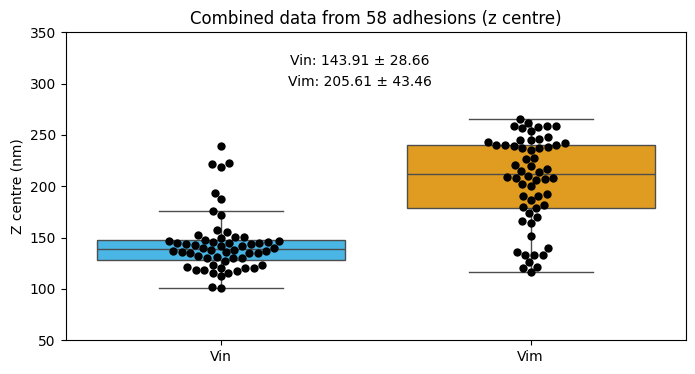

In [378]:

y1 = final_df_1_peak ['z_center_ch1']
y2 = final_df_1_peak ['z_center_ch2']

df = pd.DataFrame({'Channel': [ch_name[0]] * len(y1) + [ch_name[1]] * len(y2),
                   'Values': np.concatenate([y1, y2])})

means = df.groupby('Channel')['Values'].mean()
std_devs = df.groupby('Channel')['Values'].std()

# Create a boxplot with data points
plt.figure(figsize=(8, 4))
ax = plt.axes()

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')


box = sns.boxplot(x='Channel', y='Values', data=df, showfliers=False, hue='Channel', palette={ch_name[0]: '#30c0ff', ch_name[1]: '#ffa500'})  # Set showfliers to True if you want to display outliers
#box = sns.boxplot(x='Channel', y='Values', data=df, showfliers=False, hue='Channel', 
                  #palette={ch_name[0]: (0, 191/255, 1), ch_name[1]: '#ffa500'})

swarm = sns.swarmplot(x='Channel', y='Values', data=df, color="black", size=6)  # Add swarmplot for data points
plt.title('Combined data from '+str(len(y1)) + ' adhesions (z centre)')
plt.xlabel('')
plt.ylabel('Z centre (nm)')

# Print the mean ± standard deviation
res_Vin= f"{ch_name[0]}: {means[ch_name[0]]:.2f} ± {std_devs[ch_name[0]]:.2f}"
res_Vim= f"{ch_name[1]}: {means[ch_name[1]]:.2f} ± {std_devs[ch_name[1]]:.2f}"


plt.text(0.45, max(df['Values']+50) , res_Vin, ha='center', va='bottom',size=10)
plt.text(0.45, max(df['Values']+30) , res_Vim, ha='center', va='bottom',size=10)

plt.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)

plt.grid(False)
plt.ylim(50,350) 
plt.savefig(parent_dir_output+ "//summarised_2ch_1peak Fit_all.png", dpi=300)
plt.show()


## Additional ploting 2 fit peack data

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D
ch_name=["Vin","Vim"]

In [46]:

file_path = '/Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/all/___output_fin/final_table_all.csv'
df = pd.read_csv(file_path)
df.head()
parent_dir='/Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/___output_fin/Feb2025'

Results are saved to the folder: /Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/___output_fin/Feb2025


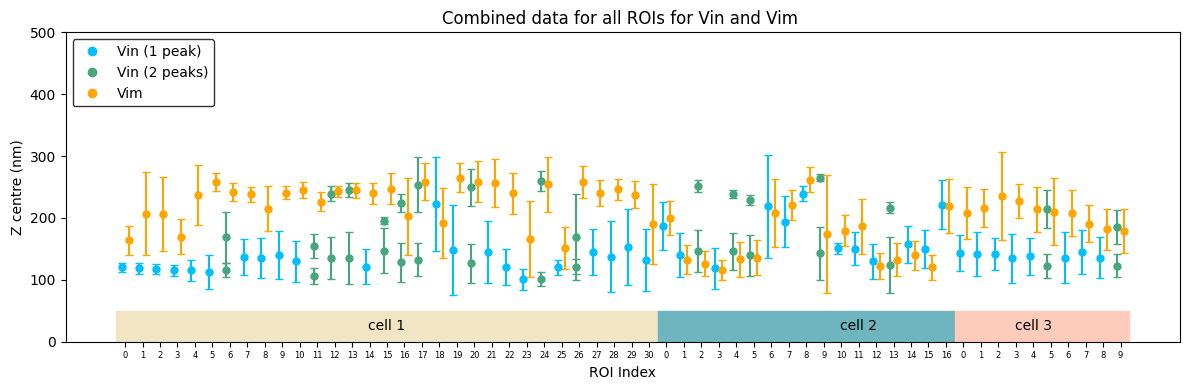

In [47]:
parent_dir_output=parent_dir
final_df = df
x_values = np.arange(len(final_df))

offset_ch1 = -0.2  
offset_ch2 = 0.2   

plt.figure(figsize=(12, 4))
ax = plt.axes()

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

legend_added_for_pick_mode_2 = False

for i, row in final_df.iterrows():
    x_base = x_values[i]  
    if row['pick_mode'] == 2:
        plt.errorbar(x_base + offset_ch1, row['z_center_ch1_p1'], yerr=row['sd_ch1_p1'], fmt='o', color='#47a67e',markersize='5', capsize=3, label=(ch_name[0]+'2 picks') if not legend_added_for_pick_mode_2 else "")
        plt.errorbar(x_base + offset_ch1, row['z_center_ch1_p2'], yerr=row['sd_ch1_p2'], fmt='o', color='#47a67e', capsize=3,markersize='5', label=(ch_name[0]+'2 picks') if not legend_added_for_pick_mode_2 else "")
        legend_added_for_pick_mode_2 = True
    else:
        plt.errorbar(x_base + offset_ch1, row['z_center_ch1'], yerr=row['sd_ch1'], fmt='o', markersize='5',color='#00bfff', capsize=3, label='Channel 1' if i == 0 else "")
plt.errorbar(x_values + offset_ch2, final_df['z_center_ch2'], yerr=final_df['sd_ch2'], fmt='o', color='#ffa500', capsize=3, label=ch_name[1],markersize='5')

plt.xlabel('ROI Index')
plt.ylabel('Z centre (nm)')
plt.title('Combined data for all ROIs for Vin and Vim ')
plt.xticks(x_values, [ind.split('_')[1] for ind in final_df['ROI_ind'].astype(str)], size=6) 
plt.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)

legend_elements = [
    Line2D([0], [0], color='#00bfff', marker='o', linestyle='None', label=(ch_name[0]+' (1 peak)')),
    Line2D([0], [0], color='#47a67e', marker='o', linestyle='None', label=(ch_name[0]+' (2 peaks)')),
    Line2D([0], [0], color='#ffa500', marker='o', linestyle='None', label=ch_name[1])
]
plt.legend(handles=legend_elements, loc='upper left', edgecolor='black')
plt.ylim(0, 500)
plt.grid(False)

# Highlight the range from 0-34 for cell1,cell2,cell3 
plt.fill_betweenx([0, 50], -0.5, (31-0.5), color='#F1E5C4', alpha=1)
plt.fill_betweenx([0, 50], (31-0.5), (31-0.5)+17, color='#6EB5C0', alpha=1)
plt.fill_betweenx([0, 50], (31+17-0.5), (31+17+10-0.5), color='#FFCCBB', alpha=1)
# Add a text label for cell
plt.text(15, 25, 'cell 1', horizontalalignment='center', verticalalignment='center', fontsize=10, color='black')
plt.text(42, 25, 'cell 2', horizontalalignment='center', verticalalignment='center', fontsize=10, color='black')
plt.text(52, 25, 'cell 3', horizontalalignment='center', verticalalignment='center', fontsize=10, color='black')
plt.tight_layout()
plt.savefig(parent_dir_output + "/allRois_2ch_with_2pickFitting_all.png", dpi=300)
print('Results are saved to the folder:', parent_dir_output)

plt.show()


Results are saved to the folder: /Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/___output_fin/Feb2025


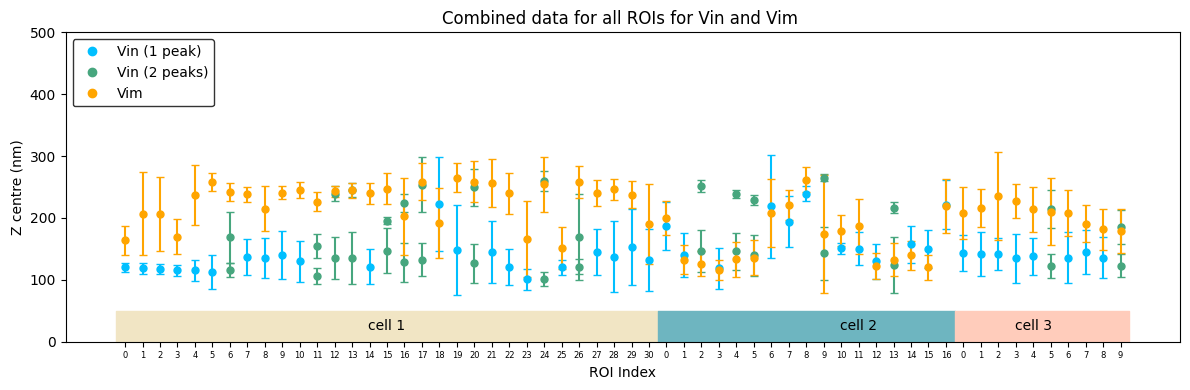

In [48]:
parent_dir_output=parent_dir
final_df = df
x_values = np.arange(len(final_df))

offset_ch1 = 0 
offset_ch2 = 0  

plt.figure(figsize=(12, 4))
ax = plt.axes()

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

legend_added_for_pick_mode_2 = False

for i, row in final_df.iterrows():
    x_base = x_values[i]  
    if row['pick_mode'] == 2:
        plt.errorbar(x_base + offset_ch1, row['z_center_ch1_p1'], yerr=row['sd_ch1_p1'], fmt='o', color='#47a67e',markersize='5', capsize=3, label=(ch_name[0]+'2 picks') if not legend_added_for_pick_mode_2 else "")
        plt.errorbar(x_base + offset_ch1, row['z_center_ch1_p2'], yerr=row['sd_ch1_p2'], fmt='o', color='#47a67e', capsize=3,markersize='5', label=(ch_name[0]+'2 picks') if not legend_added_for_pick_mode_2 else "")
        legend_added_for_pick_mode_2 = True
    else:
        plt.errorbar(x_base + offset_ch1, row['z_center_ch1'], yerr=row['sd_ch1'], fmt='o', markersize='5',color='#00bfff', capsize=3, label='Channel 1' if i == 0 else "")
plt.errorbar(x_values + offset_ch2, final_df['z_center_ch2'], yerr=final_df['sd_ch2'], fmt='o', color='#ffa500', capsize=3, label=ch_name[1],markersize='5')

plt.xlabel('ROI Index')
plt.ylabel('Z centre (nm)')
plt.title('Combined data for all ROIs for Vin and Vim ')
plt.xticks(x_values, [ind.split('_')[1] for ind in final_df['ROI_ind'].astype(str)], size=6) 
plt.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)

legend_elements = [
    Line2D([0], [0], color='#00bfff', marker='o', linestyle='None', label=(ch_name[0]+' (1 peak)')),
    Line2D([0], [0], color='#47a67e', marker='o', linestyle='None', label=(ch_name[0]+' (2 peaks)')),
    Line2D([0], [0], color='#ffa500', marker='o', linestyle='None', label=ch_name[1])
]
plt.legend(handles=legend_elements, loc='upper left', edgecolor='black')
plt.ylim(0, 500)
plt.grid(False)

# Highlight the range from 0-34 for cell1,cell2,cell3 
plt.fill_betweenx([0, 50], -0.5, (31-0.5), color='#F1E5C4', alpha=1)
plt.fill_betweenx([0, 50], (31-0.5), (31-0.5)+17, color='#6EB5C0', alpha=1)
plt.fill_betweenx([0, 50], (31+17-0.5), (31+17+10-0.5), color='#FFCCBB', alpha=1)
# Add a text label for cell
plt.text(15, 25, 'cell 1', horizontalalignment='center', verticalalignment='center', fontsize=10, color='black')
plt.text(42, 25, 'cell 2', horizontalalignment='center', verticalalignment='center', fontsize=10, color='black')
plt.text(52, 25, 'cell 3', horizontalalignment='center', verticalalignment='center', fontsize=10, color='black')
plt.tight_layout()
plt.savefig(parent_dir_output + "/allRois_2ch_with_2pickFitting_all.png", dpi=300)
print('Results are saved to the folder:', parent_dir_output)

plt.show()


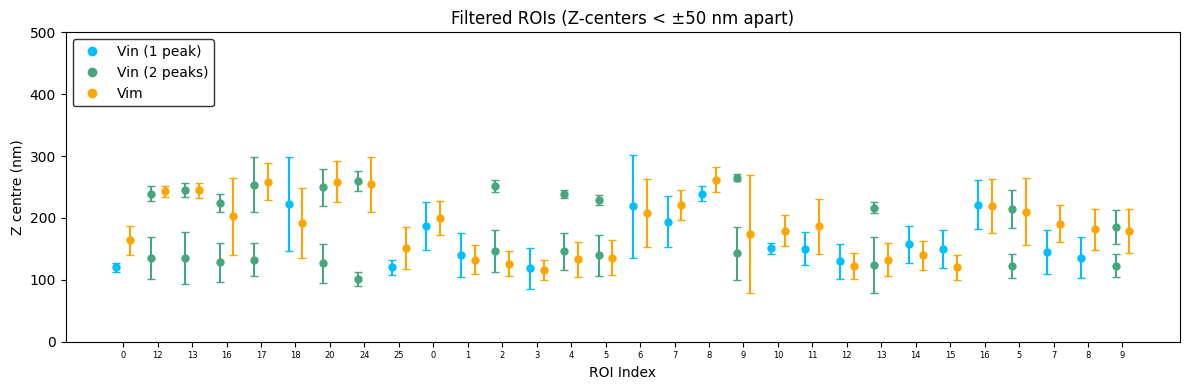

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Function to check if ROI meets the ±50 nm apart condition
def is_apart(row):
    if row['pick_mode'] == 2:
        diff_p1 = abs(row['z_center_ch1_p1'] - row['z_center_ch2'])
        diff_p2 = abs(row['z_center_ch1_p2'] - row['z_center_ch2'])
        return diff_p1 <= 50 or diff_p2 <= 50
    else:
        diff = abs(row['z_center_ch1'] - row['z_center_ch2'])
        return diff <= 50

# Apply filter
filtered_df = final_df[final_df.apply(is_apart, axis=1)].reset_index(drop=True)

# Plotting
x_values = np.arange(len(filtered_df))
offset_ch1 = -0.2  
offset_ch2 = 0.2   

plt.figure(figsize=(12, 4))
ax = plt.axes()

# Set spines
for spine in ['bottom', 'top', 'right', 'left']:
    ax.spines[spine].set_color('black')

legend_added_for_pick_mode_2 = False

# Plot Channel 1 and 2 with error bars
for i, row in filtered_df.iterrows():
    x_base = x_values[i]
    if row['pick_mode'] == 2:
        plt.errorbar(x_base + offset_ch1, row['z_center_ch1_p1'], yerr=row['sd_ch1_p1'], fmt='o', color='#47a67e',
                     markersize=5, capsize=3, label=(ch_name[0] + ' 2 picks') if not legend_added_for_pick_mode_2 else "")
        plt.errorbar(x_base + offset_ch1, row['z_center_ch1_p2'], yerr=row['sd_ch1_p2'], fmt='o', color='#47a67e',
                     markersize=5, capsize=3)
        legend_added_for_pick_mode_2 = True
    else:
        plt.errorbar(x_base + offset_ch1, row['z_center_ch1'], yerr=row['sd_ch1'], fmt='o', markersize=5, color='#00bfff',
                     capsize=3, label='Channel 1' if i == 0 else "")

plt.errorbar(x_values + offset_ch2, filtered_df['z_center_ch2'], yerr=filtered_df['sd_ch2'], fmt='o', color='#ffa500',
             capsize=3, label=ch_name[1], markersize=5)

# Labels and title
plt.xlabel('ROI Index')
plt.ylabel('Z centre (nm)')
plt.title('Filtered ROIs (Z-centers < ±50 nm apart)')

# X-ticks
plt.xticks(x_values, [ind.split('_')[1] for ind in filtered_df['ROI_ind'].astype(str)], size=6)
plt.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)

# Custom Legend
legend_elements = [
    Line2D([0], [0], color='#00bfff', marker='o', linestyle='None', label=(ch_name[0] + ' (1 peak)')),
    Line2D([0], [0], color='#47a67e', marker='o', linestyle='None', label=(ch_name[0] + ' (2 peaks)')),
    Line2D([0], [0], color='#ffa500', marker='o', linestyle='None', label=ch_name[1])
]
plt.legend(handles=legend_elements, loc='upper left', edgecolor='black')

# Plot limits and layout
plt.ylim(0, 500)
plt.grid(False)
plt.tight_layout()

# Save plot
#output_path = parent_dir_output+'/'
#plt.savefig(output_path, dpi=300)
#print('Results are saved to the folder:', output_path)

plt.show()



Results are saved to the folder: /Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/___output_fin/Feb2025/filteredRois_closeCenters.png


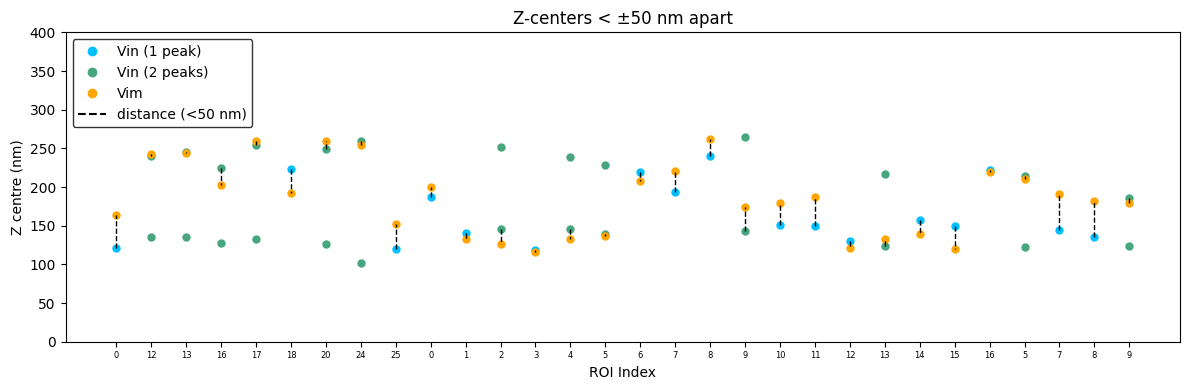

In [50]:
offset_ch1=0
offset_ch2=0
close_df=filtered_df
plt.figure(figsize=(12, 4))
ax = plt.axes()
for spine in ['bottom', 'top', 'right', 'left']:
    ax.spines[spine].set_color('black')

legend_added_for_pick_mode_2 = False

# Plot Ch 1 and 2 centers and connect only if distance < 50 nm
for i, row in close_df.iterrows():
    x_base = x_values[i]
    if row['pick_mode'] == 2:
        # Plot first peak
        diff_p1 = abs(row['z_center_ch1_p1'] - row['z_center_ch2'])
        plt.plot(x_base + offset_ch1, row['z_center_ch1_p1'], 'o', color='#47a67e', markersize=5, 
                 label=(ch_name[0] + ' 2 picks') if not legend_added_for_pick_mode_2 else "")

        # Plot second peak
        diff_p2 = abs(row['z_center_ch1_p2'] - row['z_center_ch2'])
        plt.plot(x_base + offset_ch1, row['z_center_ch1_p2'], 'o', color='#47a67e', markersize=5)

        # Plot Channel 2 center
        plt.plot(x_base + offset_ch2, row['z_center_ch2'], 'o', color='#ffa500', markersize=5, 
                 label=ch_name[1] if i == 0 else "")

        # Draw lines only if difference < 50 nm
        if diff_p1 < 50:
            plt.plot([x_base + offset_ch1, x_base + offset_ch2], [row['z_center_ch1_p1'], row['z_center_ch2']], 
                     color='black', linestyle='--', linewidth=1)
        if diff_p2 < 50:
            plt.plot([x_base + offset_ch1, x_base + offset_ch2], [row['z_center_ch1_p2'], row['z_center_ch2']], 
                     color='black', linestyle='--', linewidth=1)

        legend_added_for_pick_mode_2 = True
    else:
        # Plot single peak
        diff = abs(row['z_center_ch1'] - row['z_center_ch2'])
        plt.plot(x_base + offset_ch1, row['z_center_ch1'], 'o', markersize=5, color='#00bfff', 
                 label='Channel 1' if i == 0 else "")

        # Plot Channel 2 center
        plt.plot(x_base + offset_ch2, row['z_center_ch2'], 'o', color='#ffa500', markersize=5, 
                 label=ch_name[1] if i == 0 else "")

        # Draw line only if difference < 50 nm
        if diff < 50:
            plt.plot([x_base + offset_ch1, x_base + offset_ch2], [row['z_center_ch1'], row['z_center_ch2']], 
                     color='black', linestyle='--', linewidth=1)

# Labels and title
plt.xlabel('ROI Index')
plt.ylabel('Z centre (nm)')
plt.title('Z-centers < ±50 nm apart')

# X-ticks
plt.xticks(x_values, [ind.split('_')[1] for ind in close_df['ROI_ind'].astype(str)], size=6)
plt.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)

# Custom Legend
legend_elements = [
    Line2D([0], [0], color='#00bfff', marker='o', linestyle='None', label=(ch_name[0] + ' (1 peak)')),
    Line2D([0], [0], color='#47a67e', marker='o', linestyle='None', label=(ch_name[0] + ' (2 peaks)')),
    Line2D([0], [0], color='#ffa500', marker='o', linestyle='None', label=ch_name[1]),
    Line2D([0], [0], color='black', linestyle='--', label='distance (<50 nm)')
]
plt.legend(handles=legend_elements, loc='upper left', edgecolor='black')

# Plot limits and layout
plt.ylim(0, 400)
plt.grid(False)
plt.tight_layout()
# Save plot
output_path_close = "/Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/___output_fin/Feb2025/filteredRois_closeCenters.png"
plt.savefig(output_path_close, dpi=300)
print('Results are saved to the folder:', output_path_close)

plt.show()


Results are saved to the folder: /Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/___output_fin/Feb2025/filteredRois_closeCenters_cells.png


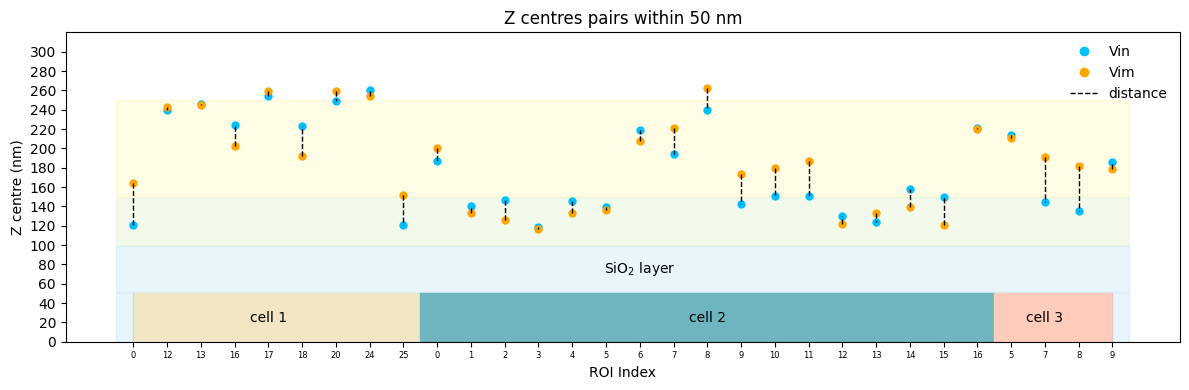

In [51]:

offset_ch1 = 0
offset_ch2 = 0
distance_threshold = 50  # Set threshold for visibility
ch1_color = '#00bfff'  # Set Channel 1 color

plt.figure(figsize=(12, 4))
ax = plt.axes()

for spine in ['bottom', 'top', 'right', 'left']:
    ax.spines[spine].set_color('black')

legend_added_for_pick_mode_2 = False
lines_to_plot = []  # Store lines to plot on top

for i, row in close_df.iterrows():
    x_base = x_values[i]

    if row['pick_mode'] == 2:
        # Calculate distances of both peaks to Ch2
        diff_p1 = abs(row['z_center_ch1_p1'] - row['z_center_ch2'])
        diff_p2 = abs(row['z_center_ch1_p2'] - row['z_center_ch2'])

        # Plot only peaks within threshold
        if diff_p1 < distance_threshold:
            plt.plot(x_base + offset_ch1, row['z_center_ch1_p1'], 'o', color=ch1_color, markersize=5, 
                     label=(ch_name[0] + ' 2 picks') if not legend_added_for_pick_mode_2 else "")
            lines_to_plot.append(((x_base + offset_ch2, x_base + offset_ch1), 
                                  (row['z_center_ch2'], row['z_center_ch1_p1'])))

        if diff_p2 < distance_threshold:
            plt.plot(x_base + offset_ch1, row['z_center_ch1_p2'], 'o', color=ch1_color, markersize=5)
            lines_to_plot.append(((x_base + offset_ch2, x_base + offset_ch1), 
                                  (row['z_center_ch2'], row['z_center_ch1_p2'])))

        legend_added_for_pick_mode_2 = True
    else:
        # Single peak case
        diff = abs(row['z_center_ch1'] - row['z_center_ch2'])
        if diff < distance_threshold:
            plt.plot(x_base + offset_ch1, row['z_center_ch1'], 'o', markersize=5, color=ch1_color, 
                     label=ch_name[0] if i == 0 else "")
            lines_to_plot.append(((x_base + offset_ch2, x_base + offset_ch1), 
                                  (row['z_center_ch2'], row['z_center_ch1'])))

    # Plot Channel 2 center
    plt.plot(x_base + offset_ch2, row['z_center_ch2'], 'o', color='#ffa500', markersize=5, 
             label=ch_name[1] if i == 0 else "")

# Plot lines on top
for line in lines_to_plot:
    plt.plot(line[0], line[1], color='black', linestyle='--', linewidth=1)


plt.xlabel('ROI Index')
plt.ylabel('Z centre (nm)')
plt.title('Z centres pairs within 50 nm')
plt.xticks(x_values, [ind.split('_')[1] for ind in close_df['ROI_ind'].astype(str)], size=6)
plt.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)

legend_elements = [
    Line2D([0], [0], color=ch1_color, marker='o', linestyle='None', label=ch_name[0]),
    Line2D([0], [0], color='#ffa500', marker='o', linestyle='None', label=ch_name[1]),
    Line2D([0], [0], color='black', linestyle='--', linewidth=1, label='distance')
]
plt.legend(handles=legend_elements, loc='upper right',frameon=False)

plt.ylim(0, 320)  # Set y-axis limits
plt.yticks(np.arange(0, 301, 20))  # Set y-axis ticks from 0 to 300 with a step of 20

plt.grid(False)

# Highlight the range for cells
plt.fill_betweenx([0, 50], 0, 8.5, color='#F1E5C4', alpha=1)
plt.fill_betweenx([0, 50], 8.5, 25.5, color='#6EB5C0', alpha=1)
plt.fill_betweenx([0, 50], 25.5, 29, color='#FFCCBB', alpha=1)
plt.fill_betweenx([100, 150], -0.5, 29.5, color='#8CD63C', alpha=0.1)
plt.fill_betweenx([151, 250], -0.5, 29.5, color='#FCE500', alpha=0.1)
plt.fill_betweenx([51, 99], -0.5, 29.5, color='#23A1E0', alpha=0.1)
plt.fill_betweenx([0, 50], -0.5, 0, color='#23A1E0', alpha=0.1)
plt.fill_betweenx([0, 50], 29, 29.5, color='#23A1E0', alpha=0.1)

plt.text(4, 25, 'cell 1', horizontalalignment='center', verticalalignment='center', fontsize=10, color='black')
plt.text(17, 25, 'cell 2', horizontalalignment='center', verticalalignment='center', fontsize=10, color='black')
plt.text(27, 25, 'cell 3', horizontalalignment='center', verticalalignment='center', fontsize=10, color='black')
plt.text(15, 75, 'SiO$_{2}$ layer', horizontalalignment='center', verticalalignment='center', fontsize=10, color='black')
plt.tight_layout()

# Save plot
output_path_close = "/Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/___output_fin/Feb2025/filteredRois_closeCenters_cells.png"
plt.savefig(output_path_close, dpi=300)
print('Results are saved to the folder:', output_path_close)

plt.show()


## >50 ver2

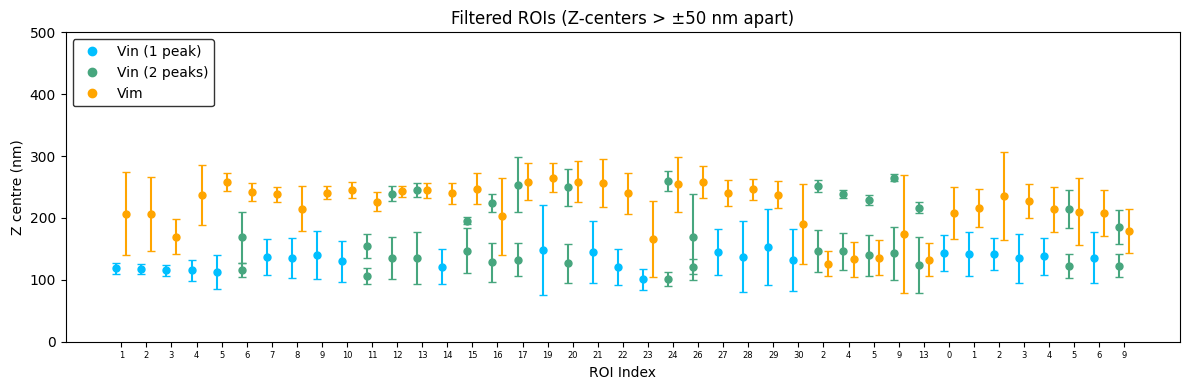

In [52]:
# Function to check if ROI meets the > 50 nm apart condition
def is_apart(row):
    if row['pick_mode'] == 2:
        diff_p1 = abs(row['z_center_ch1_p1'] - row['z_center_ch2'])
        diff_p2 = abs(row['z_center_ch1_p2'] - row['z_center_ch2'])
        return diff_p1 > 50 or diff_p2 > 50
    else:
        diff = abs(row['z_center_ch1'] - row['z_center_ch2'])
        return diff > 50

# Apply filter
filtered_df = final_df[final_df.apply(is_apart, axis=1)].reset_index(drop=True)

# Plotting
x_values = np.arange(len(filtered_df))
offset_ch1 = -0.2  
offset_ch2 = 0.2   

plt.figure(figsize=(12, 4))
ax = plt.axes()

# Set spines
for spine in ['bottom', 'top', 'right', 'left']:
    ax.spines[spine].set_color('black')

legend_added_for_pick_mode_2 = False

# Plot Channel 1 and 2 with error bars
for i, row in filtered_df.iterrows():
    x_base = x_values[i]
    if row['pick_mode'] == 2:
        plt.errorbar(x_base + offset_ch1, row['z_center_ch1_p1'], yerr=row['sd_ch1_p1'], fmt='o', color='#47a67e',
                     markersize=5, capsize=3, label=(ch_name[0] + ' 2 picks') if not legend_added_for_pick_mode_2 else "")
        plt.errorbar(x_base + offset_ch1, row['z_center_ch1_p2'], yerr=row['sd_ch1_p2'], fmt='o', color='#47a67e',
                     markersize=5, capsize=3)
        legend_added_for_pick_mode_2 = True
    else:
        plt.errorbar(x_base + offset_ch1, row['z_center_ch1'], yerr=row['sd_ch1'], fmt='o', markersize=5, color='#00bfff',
                     capsize=3, label='Channel 1' if i == 0 else "")

plt.errorbar(x_values + offset_ch2, filtered_df['z_center_ch2'], yerr=filtered_df['sd_ch2'], fmt='o', color='#ffa500',
             capsize=3, label=ch_name[1], markersize=5)

plt.xlabel('ROI Index')
plt.ylabel('Z centre (nm)')
plt.title('Filtered ROIs (Z-centers > ±50 nm apart)')

plt.xticks(x_values, [ind.split('_')[1] for ind in filtered_df['ROI_ind'].astype(str)], size=6)
plt.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)


legend_elements = [
    Line2D([0], [0], color='#00bfff', marker='o', linestyle='None', label=(ch_name[0] + ' (1 peak)')),
    Line2D([0], [0], color='#47a67e', marker='o', linestyle='None', label=(ch_name[0] + ' (2 peaks)')),
    Line2D([0], [0], color='#ffa500', marker='o', linestyle='None', label=ch_name[1])
]
plt.legend(handles=legend_elements, loc='upper left', edgecolor='black')

plt.ylim(0, 500)
plt.grid(False)
plt.tight_layout()

# Save plot
#output_path = parent_dir_output+'/'
#plt.savefig(output_path, dpi=300)
#print('Results are saved to the folder:', output_path)

plt.show()


Results are saved to the folder: /Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/___output_fin/Feb2025/filteredRois_morethen50nmCenters.png


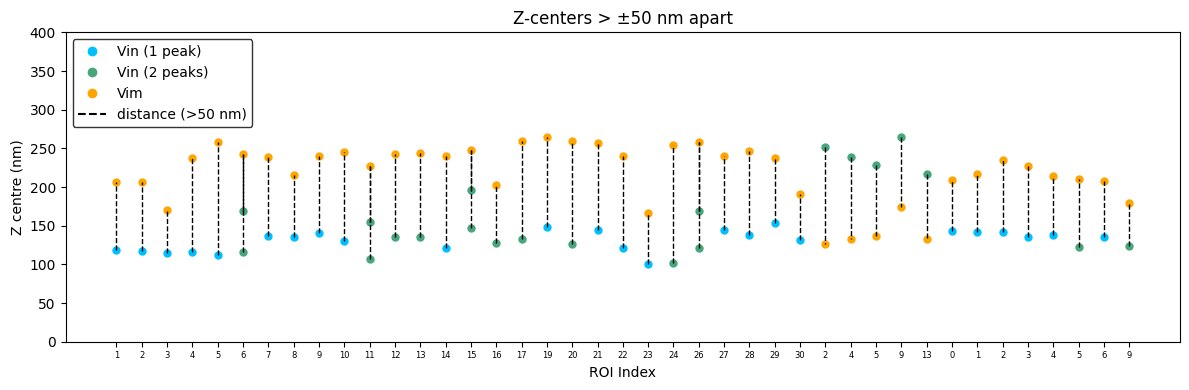

In [53]:
offset_ch1=0
offset_ch2=0
close_df=filtered_df
plt.figure(figsize=(12, 4))
ax = plt.axes()
for spine in ['bottom', 'top', 'right', 'left']:
    ax.spines[spine].set_color('black')

legend_added_for_pick_mode_2 = False

# To plot Ch 1 and 2 centers and connect only if distance > 50 nm
for i, row in close_df.iterrows():
    x_base = x_values[i]
    if row['pick_mode'] == 2:
        # Plot first peak
        diff_p1 = abs(row['z_center_ch1_p1'] - row['z_center_ch2'])
        if diff_p1 > 50:
            plt.plot(x_base + offset_ch1, row['z_center_ch1_p1'], 'o', color='#47a67e', markersize=5, 
                     label=(ch_name[0] + ' 2 picks') if not legend_added_for_pick_mode_2 else "")
        
        # Plot second peak
        diff_p2 = abs(row['z_center_ch1_p2'] - row['z_center_ch2'])
        if diff_p2 > 50:
            plt.plot(x_base + offset_ch1, row['z_center_ch1_p2'], 'o', color='#47a67e', markersize=5)
        
        # Plot Channel 2 center
        plt.plot(x_base + offset_ch2, row['z_center_ch2'], 'o', color='#ffa500', markersize=5, 
                 label=ch_name[1] if i == 0 else "")

        # Draw lines only if difference > 50 nm
        if diff_p1 > 50:
            plt.plot([x_base + offset_ch1, x_base + offset_ch2], [row['z_center_ch1_p1'], row['z_center_ch2']], 
                     color='black', linestyle='--', linewidth=1)
        if diff_p2 > 50:
            plt.plot([x_base + offset_ch1, x_base + offset_ch2], [row['z_center_ch1_p2'], row['z_center_ch2']], 
                     color='black', linestyle='--', linewidth=1)

        legend_added_for_pick_mode_2 = True
    else:
        # Plot single peak
        diff = abs(row['z_center_ch1'] - row['z_center_ch2'])
        if diff > 50:
            plt.plot(x_base + offset_ch1, row['z_center_ch1'], 'o', markersize=5, color='#00bfff', 
                     label='Channel 1' if i == 0 else "")

        # Plot Channel 2 center
        plt.plot(x_base + offset_ch2, row['z_center_ch2'], 'o', color='#ffa500', markersize=5, 
                 label=ch_name[1] if i == 0 else "")

        # Draw line only if difference > 50 nm
        if diff > 50:
            plt.plot([x_base + offset_ch1, x_base + offset_ch2], [row['z_center_ch1'], row['z_center_ch2']], 
                     color='black', linestyle='--', linewidth=1)

# Labels and title
plt.xlabel('ROI Index')
plt.ylabel('Z centre (nm)')
plt.title('Z-centers > ±50 nm apart')

plt.xticks(x_values, [ind.split('_')[1] for ind in close_df['ROI_ind'].astype(str)], size=6)
plt.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)

legend_elements = [
    Line2D([0], [0], color='#00bfff', marker='o', linestyle='None', label=(ch_name[0] + ' (1 peak)')),
    Line2D([0], [0], color='#47a67e', marker='o', linestyle='None', label=(ch_name[0] + ' (2 peaks)')),
    Line2D([0], [0], color='#ffa500', marker='o', linestyle='None', label=ch_name[1]),
    Line2D([0], [0], color='black', linestyle='--', label='distance (>50 nm)')
]
plt.legend(handles=legend_elements, loc='upper left', edgecolor='black')

plt.ylim(0, 400)
plt.grid(False)
plt.tight_layout()
# Save plot
output_path_close = "/Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/___output_fin/Feb2025/filteredRois_morethen50nmCenters.png"
plt.savefig(output_path_close, dpi=300)
print('Results are saved to the folder:', output_path_close)

plt.show()


Results are saved to the folder: /Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/___output_fin/Feb2025/filteredRois_morethen502_Centers_cells.png


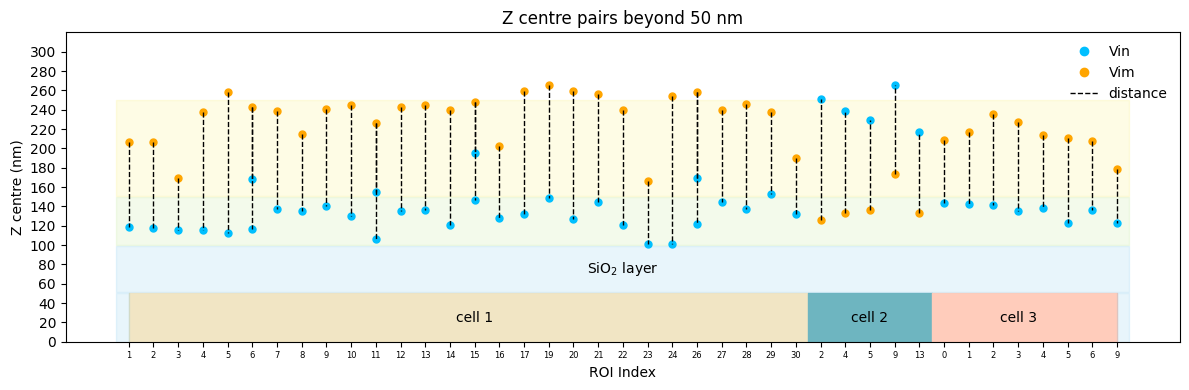

In [56]:
offset_ch1 = 0
offset_ch2 = 0
distance_threshold = 50  # Set threshold for visibility
ch1_color = '#00bfff'  # Set Channel 1 color

plt.figure(figsize=(12, 4))
ax = plt.axes()

# Set plot border color
for spine in ['bottom', 'top', 'right', 'left']:
    ax.spines[spine].set_color('black')

legend_added_for_pick_mode_2 = False
lines_to_plot = []  # Store lines to plot on top

for i, row in close_df.iterrows():
    x_base = x_values[i]

    if row['pick_mode'] == 2:
        # Calculate distances of both peaks to Ch2
        diff_p1 = abs(row['z_center_ch1_p1'] - row['z_center_ch2'])
        diff_p2 = abs(row['z_center_ch1_p2'] - row['z_center_ch2'])

        # Plot only peaks beyond threshold
        if diff_p1 > distance_threshold:
            plt.plot(x_base + offset_ch1, row['z_center_ch1_p1'], 'o', color=ch1_color, markersize=5, 
                     label=(ch_name[0] + ' 2 picks') if not legend_added_for_pick_mode_2 else "")
            lines_to_plot.append(((x_base + offset_ch2, x_base + offset_ch1), 
                                  (row['z_center_ch2'], row['z_center_ch1_p1'])))

        if diff_p2 > distance_threshold:
            plt.plot(x_base + offset_ch1, row['z_center_ch1_p2'], 'o', color=ch1_color, markersize=5)
            lines_to_plot.append(((x_base + offset_ch2, x_base + offset_ch1), 
                                  (row['z_center_ch2'], row['z_center_ch1_p2'])))

        legend_added_for_pick_mode_2 = True
    else:
        # Single peak case
        diff = abs(row['z_center_ch1'] - row['z_center_ch2'])
        if diff > distance_threshold:
            plt.plot(x_base + offset_ch1, row['z_center_ch1'], 'o', markersize=5, color=ch1_color, 
                     label=ch_name[0] if i == 0 else "")
            lines_to_plot.append(((x_base + offset_ch2, x_base + offset_ch1), 
                                  (row['z_center_ch2'], row['z_center_ch1'])))

    # Plot Channel 2 center
    plt.plot(x_base + offset_ch2, row['z_center_ch2'], 'o', color='#ffa500', markersize=5, 
             label=ch_name[1] if i == 0 else "")

for line in lines_to_plot:
    plt.plot(line[0], line[1], color='black', linestyle='--', linewidth=1)

# Labels and title
plt.xlabel('ROI Index')
plt.ylabel('Z centre (nm)')
plt.title('Z centre pairs beyond 50 nm')

plt.xticks(x_values, [ind.split('_')[1] for ind in close_df['ROI_ind'].astype(str)], size=6)
plt.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)

legend_elements = [
    Line2D([0], [0], color=ch1_color, marker='o', linestyle='None', label=ch_name[0]),
    Line2D([0], [0], color='#ffa500', marker='o', linestyle='None', label=ch_name[1]),
    Line2D([0], [0], color='black', linestyle='--', linewidth=1, label='distance')
]
plt.legend(handles=legend_elements, loc='upper right', frameon=False)

plt.ylim(0, 320)  # Set y-axis limits
plt.yticks(np.arange(0, 301, 20))  # Set y-axis ticks from 0 to 300 with a step of 20

plt.grid(False)

plt.fill_betweenx([0, 50], 0, 27.5, color='#F1E5C4', alpha=1)
plt.fill_betweenx([0, 50], 27.5, 32.5, color='#6EB5C0', alpha=1)
plt.fill_betweenx([0, 50], 32.5, 40, color='#FFCCBB', alpha=1)
plt.fill_betweenx([100, 150], -0.5, 40.5, color='#8CD63C', alpha=0.1)
plt.fill_betweenx([151, 250], -0.5, 40.5, color='#FCE500', alpha=0.1)
plt.fill_betweenx([51, 99], -0.5, 40.5, color='#23A1E0', alpha=0.1)
plt.fill_betweenx([0, 50], -0.5, 0, color='#23A1E0', alpha=0.1)
plt.fill_betweenx([0, 50], 40, 40.5, color='#23A1E0', alpha=0.1)

plt.text(14, 25, 'cell 1', horizontalalignment='center', verticalalignment='center', fontsize=10, color='black')
plt.text(30, 25, 'cell 2', horizontalalignment='center', verticalalignment='center', fontsize=10, color='black')
plt.text(36, 25, 'cell 3', horizontalalignment='center', verticalalignment='center', fontsize=10, color='black')
plt.text(20, 75, 'SiO$_{2}$ layer', horizontalalignment='center', verticalalignment='center', fontsize=10, color='black')
plt.tight_layout()

# Save plot
output_path_close = "/Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/___output_fin/Feb2025/filteredRois_morethen502_Centers_cells.png"
plt.savefig(output_path_close, dpi=300)
print('Results are saved to the folder:', output_path_close)

plt.show()


# >50

In [104]:
ch_name=["Vin","Vim"]
file_path = '/Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/all/___output_fin/final_table_all.csv'
df = pd.read_csv(file_path)
df.head()
parent_dir='/Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/___output_fin/Feb2025'

Results are saved to the folder: /Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/___output_fin/Feb2025


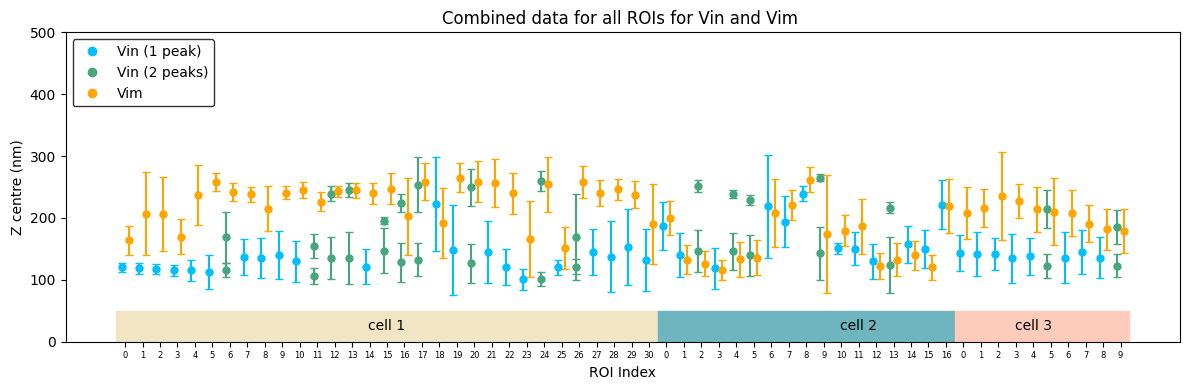

In [105]:
parent_dir_output=parent_dir
final_df = df
x_values = np.arange(len(final_df))

offset_ch1 = -0.2  
offset_ch2 = 0.2   

plt.figure(figsize=(12, 4))
ax = plt.axes()

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

legend_added_for_pick_mode_2 = False

for i, row in final_df.iterrows():
    x_base = x_values[i]  
    if row['pick_mode'] == 2:
        plt.errorbar(x_base + offset_ch1, row['z_center_ch1_p1'], yerr=row['sd_ch1_p1'], fmt='o', color='#47a67e',markersize='5', capsize=3, label=(ch_name[0]+'2 picks') if not legend_added_for_pick_mode_2 else "")
        plt.errorbar(x_base + offset_ch1, row['z_center_ch1_p2'], yerr=row['sd_ch1_p2'], fmt='o', color='#47a67e', capsize=3,markersize='5', label=(ch_name[0]+'2 picks') if not legend_added_for_pick_mode_2 else "")
        legend_added_for_pick_mode_2 = True
    else:
        plt.errorbar(x_base + offset_ch1, row['z_center_ch1'], yerr=row['sd_ch1'], fmt='o', markersize='5',color='#00bfff', capsize=3, label='Channel 1' if i == 0 else "")
plt.errorbar(x_values + offset_ch2, final_df['z_center_ch2'], yerr=final_df['sd_ch2'], fmt='o', color='#ffa500', capsize=3, label=ch_name[1],markersize='5')

plt.xlabel('ROI Index')
plt.ylabel('Z centre (nm)')
plt.title('Combined data for all ROIs for Vin and Vim ')
plt.xticks(x_values, [ind.split('_')[1] for ind in final_df['ROI_ind'].astype(str)], size=6) 
plt.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)

legend_elements = [
    Line2D([0], [0], color='#00bfff', marker='o', linestyle='None', label=(ch_name[0]+' (1 peak)')),
    Line2D([0], [0], color='#47a67e', marker='o', linestyle='None', label=(ch_name[0]+' (2 peaks)')),
    Line2D([0], [0], color='#ffa500', marker='o', linestyle='None', label=ch_name[1])
]
plt.legend(handles=legend_elements, loc='upper left', edgecolor='black')
plt.ylim(0, 500)
plt.grid(False)

plt.fill_betweenx([0, 50], -0.5, (31-0.5), color='#F1E5C4', alpha=1)
plt.fill_betweenx([0, 50], (31-0.5), (31-0.5)+17, color='#6EB5C0', alpha=1)
plt.fill_betweenx([0, 50], (31+17-0.5), (31+17+10-0.5), color='#FFCCBB', alpha=1)

plt.text(15, 25, 'cell 1', horizontalalignment='center', verticalalignment='center', fontsize=10, color='black')
plt.text(42, 25, 'cell 2', horizontalalignment='center', verticalalignment='center', fontsize=10, color='black')
plt.text(52, 25, 'cell 3', horizontalalignment='center', verticalalignment='center', fontsize=10, color='black')
plt.tight_layout()
plt.savefig(parent_dir_output + "/allRois_2ch_with_2pickFitting_all.png", dpi=300)
print('Results are saved to the folder:', parent_dir_output)

plt.show()


Results are saved to the folder: /Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/___output_fin/Feb2025/filteredRois_closeCenters.png


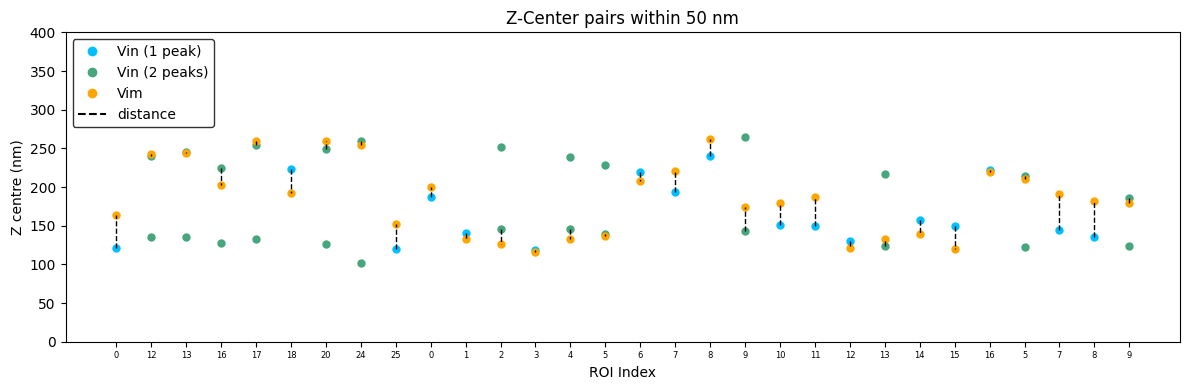

In [146]:
offset_ch1=0
offset_ch2=0

plt.figure(figsize=(12, 4))
ax = plt.axes()
for spine in ['bottom', 'top', 'right', 'left']:
    ax.spines[spine].set_color('black')

legend_added_for_pick_mode_2 = False

# Plot Ch 1 and 2 centers and connect only if distance < 50 nm
for i, row in close_df.iterrows():
    x_base = x_values[i]
    if row['pick_mode'] == 2:
        # Plot first peak
        diff_p1 = abs(row['z_center_ch1_p1'] - row['z_center_ch2'])
        plt.plot(x_base + offset_ch1, row['z_center_ch1_p1'], 'o', color='#47a67e', markersize=5, 
                 label=(ch_name[0] + ' 2 picks') if not legend_added_for_pick_mode_2 else "")

        # Plot second peak
        diff_p2 = abs(row['z_center_ch1_p2'] - row['z_center_ch2'])
        plt.plot(x_base + offset_ch1, row['z_center_ch1_p2'], 'o', color='#47a67e', markersize=5)

        # Plot Channel 2 center
        plt.plot(x_base + offset_ch2, row['z_center_ch2'], 'o', color='#ffa500', markersize=5, 
                 label=ch_name[1] if i == 0 else "")

        # Draw lines only if difference < 50 nm
        if diff_p1 < 50:
            plt.plot([x_base + offset_ch1, x_base + offset_ch2], [row['z_center_ch1_p1'], row['z_center_ch2']], 
                     color='black', linestyle='--', linewidth=1)
        if diff_p2 < 50:
            plt.plot([x_base + offset_ch1, x_base + offset_ch2], [row['z_center_ch1_p2'], row['z_center_ch2']], 
                     color='black', linestyle='--', linewidth=1)

        legend_added_for_pick_mode_2 = True
    else:
        # Plot single peak
        diff = abs(row['z_center_ch1'] - row['z_center_ch2'])
        plt.plot(x_base + offset_ch1, row['z_center_ch1'], 'o', markersize=5, color='#00bfff', 
                 label='Channel 1' if i == 0 else "")

        # Plot Channel 2 center
        plt.plot(x_base + offset_ch2, row['z_center_ch2'], 'o', color='#ffa500', markersize=5, 
                 label=ch_name[1] if i == 0 else "")

        # Draw line only if difference < 50 nm
        if diff < 50:
            plt.plot([x_base + offset_ch1, x_base + offset_ch2], [row['z_center_ch1'], row['z_center_ch2']], 
                     color='black', linestyle='--', linewidth=1)


plt.xlabel('ROI Index')
plt.ylabel('Z centre (nm)')
plt.title('Z-Center pairs within 50 nm')


plt.xticks(x_values, [ind.split('_')[1] for ind in close_df['ROI_ind'].astype(str)], size=6)
plt.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)

legend_elements = [
    Line2D([0], [0], color='#00bfff', marker='o', linestyle='None', label=(ch_name[0] + ' (1 peak)')),
    Line2D([0], [0], color='#47a67e', marker='o', linestyle='None', label=(ch_name[0] + ' (2 peaks)')),
    Line2D([0], [0], color='#ffa500', marker='o', linestyle='None', label=ch_name[1]),
    Line2D([0], [0], color='black', linestyle='--', label='distance')
]
plt.legend(handles=legend_elements, loc='upper left', edgecolor='black')

# Plot limits and layout
plt.ylim(0, 400)
plt.grid(False)
plt.tight_layout()
# Save plot
output_path_close = "/Users/Elena/Documents/Arun_2023/TXT_STORY/NY_2024/summer_2024/Z_correction/December2024/___output_fin/Feb2025/filteredRois_closeCenters.png"
plt.savefig(output_path_close, dpi=300)
print('Results are saved to the folder:', output_path_close)

plt.show()
